# Projet P7 OC Data Scientist: Implémentez un modèle de scoring 

# 1. Problématique

De nombreuses personnes ont du mal à obtenir des prêts en raison d'historiques de crédit insuffisants ou inexistants. Et, malheureusement, cette population est souvent la cible de prêteurs peu fiables.

Des entreprises comme Home Credit s'efforcent d'élargir l'inclusion financière de la population non bancarisée en offrant une expérience d'emprunt positive et sûre. Afin de s'assurer que cette population mal desservie ait une expérience de prêt positive, Home Credit utilise une variété de données alternatives (par exemple, les informations sur les télécommunications et les transactions, données comportementales) pour prédire les capacités de remboursement de leurs clients.

L'objectif de ce projet est d'utiliser les données historiques des demandes de prêt pour prédire si un demandeur sera ou non en mesure de rembourser un prêt. Il s'agit d'une tâche de classification supervisée standard :

- **Supervisé** : les étiquettes sont incluses dans les données d'apprentissage et l'objectif est d'entraîner un modèle pour apprendre à prédire les étiquettes à partir des caractéristiques

- **Classification** : L'étiquette est une variable binaire, 0 (remboursera le prêt à temps), 1 (aura des difficultés à rembourser le prêt)

Dans ce projet, les objectifs sont :
- la mise en oeuvre de routines d'exploration de données pour effectuer une analyse statistique et une visualisation.
- la mise en oeuvre de modèles de classification tels que Logistic Regression, Support Vector Machine (SVM), Random Forest, Gradient Boosting Machine (GBM), réseaux de neurones MLP Perceptron pour prédire si un demandeur pourra ou non rembourser un prêt.
- l'évaluation des modèles de classification (analyse de la précision, de la matrice de confusion, de la fonction de revenu personnalisé).
- le déploiement de la solution finale en tant qu'application Web sous forme de dashboard interactif (Streamlit) et API de prédiction (Flask).

# 2. Environnement et importation des librairies

In [1]:
# Librairies communes
from IPython.core.display import display, HTML
from datetime import datetime
import pandas as pd
import numpy as np
from scipy.stats import uniform
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px
import plotly
import pickle
import joblib
from yellowbrick.classifier import ConfusionMatrix
from yellowbrick.model_selection import FeatureImportances
from collections import Counter
from scipy.stats import loguniform
import shap

# Librairies pour l'affichage
import matplotlib.pyplot as plt
import seaborn as sns
from prettytable import PrettyTable

# Librairies diverses
import os
import gc
import pickle
import warnings
warnings.filterwarnings(action='ignore')
np.set_printoptions(suppress=True)
#pd.set_option('display.float_format', '{:.4f}'.format)

# For 100% jupyter notebook cell width
from IPython.core.display import display, HTML

# Librairies Machine Learning
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from lightgbm import LGBMClassifier, LGBMRegressor
from xgboost import XGBClassifier, XGBRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
import imblearn
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from yellowbrick.classifier import DiscriminationThreshold

# Librairie fonctions pour le projet
# Import du kernel Kaggle pour la préparation ded données
# Ancien kernel Kaggle
#from p7_preprocess_data_eda_kernel_kaggle import *

# Nouveau kernel Kaggle
from p7_data_preparation_kernel_kaggle import *
from p7_eda_kernel_kaggle import *

# Fonctions pour le projet P7
from p7_functions import *

# Pandas DataFrame column and row display limits
pd.set_option('max_columns', None)
pd.set_option('max_rows', None)

# Versions des librairies
print("Version librairie pandas: " + pd.__version__)
print("Version librairie numpy: " + np.__version__)
print("Version librairie matplotlib: " + matplotlib.__version__)
print("Version librairie seaborn: " + sns.__version__)
print("Version librairie imblearn: " + imblearn.__version__)

Version librairie pandas: 1.3.0
Version librairie numpy: 1.19.5
Version librairie matplotlib: 3.3.2
Version librairie seaborn: 0.11.0
Version librairie imblearn: 0.8.1


# 3. Fonctions

In [2]:
# Affichage des informations sur un dataset
def display_dataset_general_info(df_in, df_in_desc, info_suppl, id_df_in_merge_pk,
                                 id_df_in_merge_fk, df_in_application_train, df_in_application_test):
    print('Dimensions du dataset ' + df_in_desc +  ' est: ' + str(df_in.shape))
    print('-'*100)
    if info_suppl != None:
        print('Nombre d\'identifiants uniques ' + id_df_in_merge_pk + ' dans ' + df_in_desc 
              + ': ' +  str(len(df_in[id_df_in_merge_pk].unique())))
        print('Nombre d\'identifiants clés étrangères ' + id_df_in_merge_fk + ' dans ' + df_in_desc 
              + ': ' +  str(len(df_in[id_df_in_merge_fk].unique())))
        print('Nombre de correspondances ' + id_df_in_merge_fk 
              + ' entre dataset application_train et ' + df_in_desc + ': ' +
              str(len(set(df_in_application_train[id_df_in_merge_fk].unique()).intersection(set(df_in[id_df_in_merge_fk].unique())))))
        print('Nombre de correspondances ' + id_df_in_merge_fk 
              + ' entre dataset application_test et ' + df_in_desc + ': ' +
              str(len(set(df_in_application_test[id_df_in_merge_fk].unique()).intersection(set(df_in[id_df_in_merge_fk].unique())))))
        print('-'*100)
        
    print('Nombre de valeurs dupliquées dans ' +  df_in_desc + ': ' +  str(df_in.shape[0] - df_in.duplicated().shape[0]))
    print('-'*100)
    display(df_in.head())

In [3]:
# Fonction pour supprimer les colonnes d'un dataset 35 % ou plus de valeurs NaN
def drop_column_perc_nan(df_in, perc_nan):
    mod_df_in = df_in.copy()
    min_count =  int(((100-perc_nan)/100)*mod_df_in.shape[0] + 1)
    mod_df_in.dropna( axis=1, thresh=min_count, inplace=True)
    
    return mod_df_in

In [4]:
# Fonction pour standardisation des données du dataset
def std_dataset(df_in, method_std):
    df_in_std = pd.DataFrame(method_std.fit_transform(df_in), columns = df_in.columns)
    
    return df_in_std

In [5]:
# Fonction pour optimiser valeur k de KNN
def optimize_k(data, target):
    errors = []
    for k in range(1, 20, 2):
        print("k: " + str(k))
        imputer = KNNImputer(n_neighbors=k)
        imputed = imputer.fit_transform(data)
        df_imputed = pd.DataFrame(imputed, columns=df.columns)
        
        X = df_imputed
        y = df_imputed[target]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        model = LogisticRegression()
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        error = rmse(y_test, preds)
        errors.append({'K': k, 'RMSE': error})
        print(errors)
        
    return errors

In [6]:
# Fonction pour imputation KNN
def imputation_nan_knn(df_in, k):
    imputer = KNNImputer(n_neighbors=k)
    imputed = imputer.fit_transform(df_in)
    df_imputed = pd.DataFrame(imputed, columns=df.columns)
    
    return df_imputed

In [7]:
# Fonction pour modelisation simple baseline
def model_baseline(model, model_name, X_train, y_train, X_test, y_test, 
                   df_save_metrics, cost_function_flag, tnrw, tprw, fpcw, fncw, 
                   class_weight_flag):
    # Entraînement du modèle sur le dataset train
    model.fit(X_train, y_train)

    # Prédictions sur les données test
    y_pred = model.predict(X_test)
    
    # Métriques    
    # AUC
    auc = metrics.roc_auc_score(y_test, y_pred)
    print("AUC score: ", str(auc))
    
    # Accuracy
    accuracy = metrics.accuracy_score(y_test, y_pred)
    
    # Métriques pour chaque classe 0 et 1 (precision, recall (sensitivity et specificity), fscore)
    metrics_by_class = metrics.precision_recall_fscore_support(y_test,y_pred)
    
    # Matrice de confusion
    cm = metrics.confusion_matrix(y_test, y_pred)
    
    if class_weight_flag != None:
        class_weight = "Class weights"
    else:
        class_weight = "N/A"
    
    if cost_function_flag != None:
        # Calcul de la fonction de coût personnalisée
        ccf, ocf = eval_custom_metric(cm, tnrw, tprw, fpcw, fncw)
    
        # Enregistrement des résultats des métriques
        df_results = save_results_metrics(df_save_metrics, model_name, class_weight, 
                                      "N/A", accuracy, auc,
                                      round(ccf,0), round(ocf,0), round(ccf/ocf,4), 
                                      metrics_by_class)
    else:
        # Enregistrement des résultats des métriques
        df_results = save_results_metrics(df_save_metrics, model_name, class_weight, 
                                      "N/A", accuracy, auc,
                                      "N/A", "N/A", "N/A", 
                                      metrics_by_class)
    
    # Rapport de classification
    classif_report = metrics.classification_report(y_test, y_pred)
          
    return cm, classif_report, df_results      

In [8]:
# Fonction pour affichage matrice de confusion
def display_matrix_confusion(confusion_matrix):
    
    labels = ['True Neg','False Pos','False Neg','True Pos'] 
    categories = ['0 - Non Defaulter', '1 - Defaulter'] 
    make_confusion_matrix(confusion_matrix, 
                      group_names=labels, 
                      categories=categories, 
                      cmap='Blues',
                      cbar=False,
                      sum_stats=False,
                      figsize=(4,4))
    
    return None

In [9]:
# Fonction pour l'enregistrement des résultats des métriques des classifieurs
def save_results_metrics(df_in, model, method_imb, optim_param, acc, 
                         auc, cost_function, optimum_cost_function, 
                         ratio_custom_optim_cost, 
                         metrics_class):
    # Tableau vide
    if df_in.shape[0] == 0:
        df_in.loc[0]=[model, method_imb, optim_param, acc,
                      auc, 
                      cost_function, optimum_cost_function, 
                      ratio_custom_optim_cost, 
                      metrics_class[0][0], metrics_class[0][1],
                      metrics_class[1][0], metrics_class[1][1],
                      metrics_class[2][0], metrics_class[2][1]]
        
    # Tableau non vide
    else:    
        df_in.loc[df_in.shape[0]]=[model, method_imb, optim_param, acc, 
                                   auc, 
                                   cost_function, optimum_cost_function,
                                   ratio_custom_optim_cost,
                                   metrics_class[0][0], metrics_class[0][1],
                                   metrics_class[1][0], metrics_class[1][1],
                                   metrics_class[2][0], metrics_class[2][1]]
        
    return df_in

In [10]:
# Fonction pour calculer métrique personnalisée - fonction de coût
def eval_custom_metric(confusion_matrix, tnrw, tprw, fpcw, fncw):
    tn = confusion_matrix[0][0]
    fp = confusion_matrix[0][1]
    fn = confusion_matrix[1][0]
    tp = confusion_matrix[1][1]
    
    # Fonction de coût / revenu net
    revenue_net = tn*tnrw + tp*tprw + fn*fncw + fp*fpcw
    
    # Fonction de coût / revenu net idéale 
    # avec des prédictions de classes sans erreur
    
    revenue_net_optim = (tn+fp)*tnrw + (tp+fn)*tprw
    
    return revenue_net, revenue_net_optim

In [11]:
# Fonction pour modelisation classifier baseline avec LogisticRegression
# Détermination de la méthode de traitement de déséquilibrage des classes
def eval_imbalance_class_method(over_sample, under_sample, class_weight,
                                X_train, y_train, X_test, y_test, df_save_metrics,
                                tnrw, tprw, fprw, fncw, method_imb_name):
    
    # Nombre individus par classe sur y_train
    print("Nombre individus par classe sur y_train:")
    print(Counter(y_train))
    
    # Instanciation du modèle LogisticRegression
    model = LogisticRegression()
    
    # Détermination des étapes du pipeline imblearn
    if over_sample == None and under_sample == None and class_weight == None:
        print("Il faut passer un méthode over ou undersempling ou class weight")
        return None
    
    elif (over_sample != None and under_sample == None):
        print("Méthode de sur-échantillonnage: " + method_imb_name)
        # Pipeline imblearn
        steps = [('mth_imb', over_sample)]
            
    elif (over_sample == None and under_sample != None):
        print("Méthode de sous-échantillonnage: " + method_imb_name)
        # Pipeline imblearn
        steps = [('mth_imb', under_sample)]
        
    else:
        print("Cas non géré")
        return None
    
    pipeline = Pipeline(steps=steps)
    
    # Rééchantillonnage des classes déséquilibrées
    X_train_imb, y_train_imb = pipeline.fit_resample(X_train, y_train)
        
    # Nombre individus par classe sur y_train_imb
    print("Nombre individus par classe sur y_train_imb après rééquilibrage des classes:")
    print(Counter(y_train_imb))

    # Entraînement du modèle sur le dataset train
    model.fit(X_train_imb, y_train_imb)

    # Prédictions sur les données test
    y_pred = model.predict(X_test)
    
    # Métriques    
    # AUC
    auc = metrics.roc_auc_score(y_test, y_pred)
    print("AUC score: ", str(auc))
    
    # Accuracy
    accuracy = metrics.accuracy_score(y_test, y_pred)
    
    # Métriques pour chaque classe 0 et 1 (precision, recall (sensitivity et specificity), fscore)
    metrics_by_class = metrics.precision_recall_fscore_support(y_test,y_pred)
    
    # Matrice de confusion
    cm = metrics.confusion_matrix(y_test, y_pred)
    
    # Calcul de la fonction de coût personnalisée
    ccf, ocf = eval_custom_metric(cm, tnrw, tprw, fpcw, fncw)
    
    # Enregistrement des résultats des métriques
    df_results = save_results_metrics(df_save_metrics, "LogisticRegression",
                                      method_imb_name, "N/A",
                                      accuracy, auc,
                                      ccf, ocf, round(ccf/ocf,4), metrics_by_class)
    
    # Rapport de classification
    classif_report = metrics.classification_report(y_test, y_pred)
          
    return cm, classif_report, df_results, X_train_imb, y_train_imb

In [12]:
def optim_hyperparam_model(X_train, X_test, y_train, y_test, model, 
                                   param_grid, model_txt, nb_fold):

    print('Optimisation des hyper-paramètres pour le modèle ' + model_txt)
    print('---------------------------------------------------------------------------------')
    print('')
    
    # Date de début de traitement
    start = datetime.now()
    
    model_grid = GridSearchCV(estimator=model, 
                      param_grid = param_grid,
                      scoring = 'roc_auc',
                      cv=nb_fold,
                      verbose=2,
                      n_jobs=1,       
                     )
    
    # Entraînement du modèle
    model_grid.fit(X_train, y_train)
    
    print("best score: ", model_grid.best_score_)
    print("best param: ", model_grid.best_params_)
    
    # Sauvegarde des hyper-paramètres optimisés
    joblib.dump(model_grid.best_params_,
                './input/'+model_txt+'_'+'optim_params.pkl')
    
    # Durée du traitement
    print(f'Durée traitement optimisation hyper-paramètres = {datetime.now() - start}')
    
    return None

In [13]:
# Fonction pour la prédiction des valeurs cible
def predict_model(X_train, y_train, X_test, y_test, model, model_txt,
                  fic_hyperparam, tnrw, tprw, fpcw, fncw, df_save_metrics, 
                  threshold, method_imb_name):
    
    # Chargement du fichier des hyper-paramètres
    loaded_hyp_param = joblib.load(fic_hyperparam)
    print('-----------------------------------------------------------------------------')
    print('Entraînement du modèle sur les hyper-paramètres optimisés: ' + model_txt)
    print('-----------------------------------------------------------------------------')
    print('Chargement du fichier des hyper-paramètres: ' + fic_hyperparam) 
    print('Hyper-paramètres optimisés: ' + str(loaded_hyp_param))
    
    
    model.set_params(**loaded_hyp_param)
    print('Prédictions avec les paramètres suivants du modèle:')
    print(model.get_params())
    print('')
    
    # Entraînement du modèle sur le dataset train
    model.fit(X_train, y_train)
   
    # Prédictions sur le train et test set
    if threshold == None:
        y_pred_train = model.predict(X_train)
        y_pred_test = model.predict(X_test)
    
    elif threshold >= 0 and threshold <=1:
        y_pred_train = model.predict_proba(X_train)
        y_pred_test = model.predict_proba(X_test)
        
        y_pred_train = (y_pred_train[::,1] > threshold )*1
        y_pred_test = (y_pred_test[::,1] > threshold )*1
    else:
        print('Valeur de seuil non gérée')

    
    # Métriques    
    # AUC
    auc_train = metrics.roc_auc_score(y_train, y_pred_train)
    auc_test = metrics.roc_auc_score(y_test, y_pred_test)
    print("AUC score train: ", str(auc_train))
    print("AUC score test: ", str(auc_test))
    
    # Accuracy
    accuracy = metrics.accuracy_score(y_test, y_pred_test)
    
    # Métriques pour chaque classe 0 et 1 (precision, recall (sensitivity et specificity), fscore)
    metrics_by_class = metrics.precision_recall_fscore_support(y_test,y_pred_test)
    
    # Matrice de confusion
    cm = metrics.confusion_matrix(y_test, y_pred_test)
    
    # Calcul de la fonction de coût personnalisée
    ccf, ocf = eval_custom_metric(cm, tnrw, tprw, fpcw, fncw)
    
    # Enregistrement des résultats des métriques
    df_results = save_results_metrics(df_save_metrics, model_txt,
                                      method_imb_name, loaded_hyp_param,
                                      accuracy, auc_test,
                                      ccf, ocf, round(ccf/ocf,4), metrics_by_class)
    
    # Rapport de classification
    classif_report = metrics.classification_report(y_test, y_pred_test) 
    
    return cm, classif_report, df_results

In [14]:
# Fonction pour afficher le seuil de discrimination
def display_seuil_discrimination(model, X_train, y_train, X_test, y_test):
    viz = DiscriminationThreshold(model,
                                  cv=0.2,
                                  fig=plt.figure(figsize=(9,6)))

    viz.fit(X_train, y_train)

    #viz.score(X_test, y_test)

    viz.show()
    
    return None

# 4. Chargement des données pour modélisation

In [15]:
# Chargement des données dataset final (sans standardisation)
train_data_mod_tr_nan = pd.read_csv('./Input/dataset_final/train_data_mod_tr_nan_id.csv', sep=",")

In [16]:
train_data_mod_tr_nan.shape

(307507, 334)

In [17]:
train_data_mod_tr_nan.head(3)

,SK_ID_CURR,APPROVED_AMT_DOWN_PAYMENT_MAX,ORGANIZATION_TYPE_Military,INSTAL_PAYMENT_PERC_VAR,PREV_NAME_YIELD_GROUP_middle_MEAN,APPROVED_AMT_ANNUITY_MIN,PREV_NAME_CASH_LOAN_PURPOSE_Urgentneeds_MEAN,APPROVED_AMT_CREDIT_MEAN,APPROVED_APP_CREDIT_PERC_MEAN,BURO_DAYS_CREDIT_MIN,PREV_NAME_CONTRACT_STATUS_Canceled_MEAN,POS_SK_DPD_MEAN,ORGANIZATION_TYPE_School,WEEKDAY_APPR_PROCESS_START_SUNDAY,PREV_RATE_DOWN_PAYMENT_MAX,PREV_PRODUCT_COMBINATION_POSmobilewithinterest_MEAN,BURO_CREDIT_TYPE_Consumercredit_MEAN,NAME_TYPE_SUITE_Spousepartner,PREV_PRODUCT_COMBINATION_POShouseholdwithinterest_MEAN,PREV_AMT_GOODS_PRICE_MAX,INSTAL_PAYMENT_PERC_MAX,FLAG_DOCUMENT_3,DEF_30_CNT_SOCIAL_CIRCLE,APPROVED_AMT_DOWN_PAYMENT_MIN,AMT_REQ_CREDIT_BUREAU_QRT,NAME_HOUSING_TYPE_Withparents,BURO_AMT_CREDIT_SUM_DEBT_SUM,PREV_NAME_GOODS_CATEGORY_Furniture_MEAN,APPROVED_HOUR_APPR_PROCESS_START_MAX,NAME_HOUSING_TYPE_Officeapartment,PREV_CODE_REJECT_REASON_XNA_MEAN,BURO_CREDIT_TYPE_Microloan_MEAN,ORGANIZATION_TYPE_Government,PREV_NAME_SELLER_INDUSTRY_Autotechnology_MEAN,WEEKDAY_APPR_PROCESS_START_TUESDAY,PREV_AMT_ANNUITY_MIN,DAYS_ID_PUBLISH,PREV_NAME_GOODS_CATEGORY_Homewares_MEAN,APPROVED_AMT_CREDIT_MAX,BURO_CREDIT_ACTIVE_Sold_MEAN,PREV_PRODUCT_COMBINATION_CashXSelllow_MEAN,PREV_NAME_TYPE_SUITE_Groupofpeople_MEAN,PREV_NAME_TYPE_SUITE_nan_MEAN,POS_NAME_CONTRACT_STATUS_Active_MEAN,INSTAL_PAYMENT_DIFF_MAX,OCCUPATION_TYPE_Salesstaff,BURO_CNT_CREDIT_PROLONG_SUM,INSTAL_DBD_MAX,POS_SK_DPD_DEF_MAX,PREV_NAME_CASH_LOAN_PURPOSE_XNA_MEAN,PREV_CODE_REJECT_REASON_HC_MEAN,PREV_NAME_TYPE_SUITE_Family_MEAN,HOUR_APPR_PROCESS_START,PREV_NAME_PORTFOLIO_Cash_MEAN,index,PREV_NAME_PAYMENT_TYPE_Noncashfromyouraccount_MEAN,PREV_NAME_GOODS_CATEGORY_ClothingandAccessories_MEAN,PREV_NAME_CASH_LOAN_PURPOSE_Everydayexpenses_MEAN,PREV_NAME_CLIENT_TYPE_New_MEAN,NAME_FAMILY_STATUS_Civilmarriage,PREV_PRODUCT_COMBINATION_CashStreetmiddle_MEAN,PREV_AMT_APPLICATION_MIN,ORGANIZATION_TYPE_Advertising,INSTAL_DAYS_ENTRY_PAYMENT_MEAN,BURO_MONTHS_BALANCE_SIZE_SUM,INCOME_PER_PERSON,PREV_AMT_CREDIT_MEAN,INSTAL_DAYS_ENTRY_PAYMENT_SUM,APPROVED_AMT_ANNUITY_MEAN,POS_NAME_CONTRACT_STATUS_Returnedtothestore_MEAN,PREV_NAME_TYPE_SUITE_Other_B_MEAN,INSTAL_PAYMENT_PERC_MEAN,PREV_AMT_ANNUITY_MAX,INSTAL_PAYMENT_PERC_SUM,PREV_PRODUCT_COMBINATION_Cash_MEAN,INSTAL_AMT_INSTALMENT_MEAN,OBS_30_CNT_SOCIAL_CIRCLE,PREV_NAME_GOODS_CATEGORY_ConstructionMaterials_MEAN,ORGANIZATION_TYPE_BusinessEntityType2,PREV_NAME_CONTRACT_TYPE_Cashloans_MEAN,PREV_CHANNEL_TYPE_Channelofcorporatesales_MEAN,PREV_NAME_GOODS_CATEGORY_Tourism_MEAN,PREV_AMT_GOODS_PRICE_MEAN,PREV_NAME_CONTRACT_TYPE_Revolvingloans_MEAN,OBS_60_CNT_SOCIAL_CIRCLE,PREV_PRODUCT_COMBINATION_POShouseholdwithoutinterest_MEAN,BURO_CREDIT_TYPE_Loanforworkingcapitalreplenishment_MEAN,PREV_NAME_YIELD_GROUP_XNA_MEAN,INSTAL_AMT_PAYMENT_MIN,POS_MONTHS_BALANCE_MEAN,APPROVED_AMT_APPLICATION_MEAN,PREV_CNT_PAYMENT_SUM,PREV_CODE_REJECT_REASON_XAP_MEAN,PREV_NAME_GOODS_CATEGORY_DirectSales_MEAN,AMT_INCOME_TOTAL,PREV_NAME_PRODUCT_TYPE_walkin_MEAN,PREV_DAYS_DECISION_MEAN,BURO_AMT_CREDIT_SUM_OVERDUE_MEAN,PREV_NAME_TYPE_SUITE_Spousepartner_MEAN,HOUSETYPE_MODE_specifichousing,PREV_NAME_PAYMENT_TYPE_Cashthroughthebank_MEAN,PREV_WEEKDAY_APPR_PROCESS_START_SUNDAY_MEAN,PREV_NAME_PAYMENT_TYPE_XNA_MEAN,BURO_CREDIT_TYPE_Mortgage_MEAN,BURO_DAYS_CREDIT_ENDDATE_MEAN,POS_MONTHS_BALANCE_SIZE,EMERGENCYSTATE_MODE_No,LIVE_REGION_NOT_WORK_REGION,PREV_AMT_ANNUITY_MEAN,APPROVED_RATE_DOWN_PAYMENT_MAX,FONDKAPREMONT_MODE_regoperaccount,APPROVED_AMT_CREDIT_MIN,BURO_CREDIT_DAY_OVERDUE_MAX,CNT_CHILDREN,PREV_WEEKDAY_APPR_PROCESS_START_WEDNESDAY_MEAN,POS_SK_DPD_MAX,ORGANIZATION_TYPE_BusinessEntityType3,ORGANIZATION_TYPE_Construction,PREV_HOUR_APPR_PROCESS_START_MAX,PREV_HOUR_APPR_PROCESS_START_MIN,APPROVED_CNT_PAYMENT_MEAN,PREV_NAME_CASH_LOAN_PURPOSE_Businessdevelopment_MEAN,PREV_NAME_YIELD_GROUP_low_normal_MEAN,ORGANIZATION_TYPE_Industrytype9,DAYS_LAST_PHONE_CHANGE,APPROVED_AMT_GOODS_PRICE_MEAN,INSTAL_AMT_INSTALMENT_MAX,INSTAL

In [18]:
# Chargement des données dataset final (avec standardisation)
train_data_mod_tr_nan_std = pd.read_csv('./Input/dataset_final/train_data_mod_tr_nan_std_id.csv', sep=",")

In [19]:
train_data_mod_tr_nan_std.shape

(307507, 334)

In [20]:
train_data_mod_tr_nan_std.head(3)

,SK_ID_CURR,APPROVED_AMT_DOWN_PAYMENT_MAX,ORGANIZATION_TYPE_Military,INSTAL_PAYMENT_PERC_VAR,PREV_NAME_YIELD_GROUP_middle_MEAN,APPROVED_AMT_ANNUITY_MIN,PREV_NAME_CASH_LOAN_PURPOSE_Urgentneeds_MEAN,APPROVED_AMT_CREDIT_MEAN,APPROVED_APP_CREDIT_PERC_MEAN,BURO_DAYS_CREDIT_MIN,PREV_NAME_CONTRACT_STATUS_Canceled_MEAN,POS_SK_DPD_MEAN,ORGANIZATION_TYPE_School,WEEKDAY_APPR_PROCESS_START_SUNDAY,PREV_RATE_DOWN_PAYMENT_MAX,PREV_PRODUCT_COMBINATION_POSmobilewithinterest_MEAN,BURO_CREDIT_TYPE_Consumercredit_MEAN,NAME_TYPE_SUITE_Spousepartner,PREV_PRODUCT_COMBINATION_POShouseholdwithinterest_MEAN,PREV_AMT_GOODS_PRICE_MAX,INSTAL_PAYMENT_PERC_MAX,FLAG_DOCUMENT_3,DEF_30_CNT_SOCIAL_CIRCLE,APPROVED_AMT_DOWN_PAYMENT_MIN,AMT_REQ_CREDIT_BUREAU_QRT,NAME_HOUSING_TYPE_Withparents,BURO_AMT_CREDIT_SUM_DEBT_SUM,PREV_NAME_GOODS_CATEGORY_Furniture_MEAN,APPROVED_HOUR_APPR_PROCESS_START_MAX,NAME_HOUSING_TYPE_Officeapartment,PREV_CODE_REJECT_REASON_XNA_MEAN,BURO_CREDIT_TYPE_Microloan_MEAN,ORGANIZATION_TYPE_Government,PREV_NAME_SELLER_INDUSTRY_Autotechnology_MEAN,WEEKDAY_APPR_PROCESS_START_TUESDAY,PREV_AMT_ANNUITY_MIN,DAYS_ID_PUBLISH,PREV_NAME_GOODS_CATEGORY_Homewares_MEAN,APPROVED_AMT_CREDIT_MAX,BURO_CREDIT_ACTIVE_Sold_MEAN,PREV_PRODUCT_COMBINATION_CashXSelllow_MEAN,PREV_NAME_TYPE_SUITE_Groupofpeople_MEAN,PREV_NAME_TYPE_SUITE_nan_MEAN,POS_NAME_CONTRACT_STATUS_Active_MEAN,INSTAL_PAYMENT_DIFF_MAX,OCCUPATION_TYPE_Salesstaff,BURO_CNT_CREDIT_PROLONG_SUM,INSTAL_DBD_MAX,POS_SK_DPD_DEF_MAX,PREV_NAME_CASH_LOAN_PURPOSE_XNA_MEAN,PREV_CODE_REJECT_REASON_HC_MEAN,PREV_NAME_TYPE_SUITE_Family_MEAN,HOUR_APPR_PROCESS_START,PREV_NAME_PORTFOLIO_Cash_MEAN,index,PREV_NAME_PAYMENT_TYPE_Noncashfromyouraccount_MEAN,PREV_NAME_GOODS_CATEGORY_ClothingandAccessories_MEAN,PREV_NAME_CASH_LOAN_PURPOSE_Everydayexpenses_MEAN,PREV_NAME_CLIENT_TYPE_New_MEAN,NAME_FAMILY_STATUS_Civilmarriage,PREV_PRODUCT_COMBINATION_CashStreetmiddle_MEAN,PREV_AMT_APPLICATION_MIN,ORGANIZATION_TYPE_Advertising,INSTAL_DAYS_ENTRY_PAYMENT_MEAN,BURO_MONTHS_BALANCE_SIZE_SUM,INCOME_PER_PERSON,PREV_AMT_CREDIT_MEAN,INSTAL_DAYS_ENTRY_PAYMENT_SUM,APPROVED_AMT_ANNUITY_MEAN,POS_NAME_CONTRACT_STATUS_Returnedtothestore_MEAN,PREV_NAME_TYPE_SUITE_Other_B_MEAN,INSTAL_PAYMENT_PERC_MEAN,PREV_AMT_ANNUITY_MAX,INSTAL_PAYMENT_PERC_SUM,PREV_PRODUCT_COMBINATION_Cash_MEAN,INSTAL_AMT_INSTALMENT_MEAN,OBS_30_CNT_SOCIAL_CIRCLE,PREV_NAME_GOODS_CATEGORY_ConstructionMaterials_MEAN,ORGANIZATION_TYPE_BusinessEntityType2,PREV_NAME_CONTRACT_TYPE_Cashloans_MEAN,PREV_CHANNEL_TYPE_Channelofcorporatesales_MEAN,PREV_NAME_GOODS_CATEGORY_Tourism_MEAN,PREV_AMT_GOODS_PRICE_MEAN,PREV_NAME_CONTRACT_TYPE_Revolvingloans_MEAN,OBS_60_CNT_SOCIAL_CIRCLE,PREV_PRODUCT_COMBINATION_POShouseholdwithoutinterest_MEAN,BURO_CREDIT_TYPE_Loanforworkingcapitalreplenishment_MEAN,PREV_NAME_YIELD_GROUP_XNA_MEAN,INSTAL_AMT_PAYMENT_MIN,POS_MONTHS_BALANCE_MEAN,APPROVED_AMT_APPLICATION_MEAN,PREV_CNT_PAYMENT_SUM,PREV_CODE_REJECT_REASON_XAP_MEAN,PREV_NAME_GOODS_CATEGORY_DirectSales_MEAN,AMT_INCOME_TOTAL,PREV_NAME_PRODUCT_TYPE_walkin_MEAN,PREV_DAYS_DECISION_MEAN,BURO_AMT_CREDIT_SUM_OVERDUE_MEAN,PREV_NAME_TYPE_SUITE_Spousepartner_MEAN,HOUSETYPE_MODE_specifichousing,PREV_NAME_PAYMENT_TYPE_Cashthroughthebank_MEAN,PREV_WEEKDAY_APPR_PROCESS_START_SUNDAY_MEAN,PREV_NAME_PAYMENT_TYPE_XNA_MEAN,BURO_CREDIT_TYPE_Mortgage_MEAN,BURO_DAYS_CREDIT_ENDDATE_MEAN,POS_MONTHS_BALANCE_SIZE,EMERGENCYSTATE_MODE_No,LIVE_REGION_NOT_WORK_REGION,PREV_AMT_ANNUITY_MEAN,APPROVED_RATE_DOWN_PAYMENT_MAX,FONDKAPREMONT_MODE_regoperaccount,APPROVED_AMT_CREDIT_MIN,BURO_CREDIT_DAY_OVERDUE_MAX,CNT_CHILDREN,PREV_WEEKDAY_APPR_PROCESS_START_WEDNESDAY_MEAN,POS_SK_DPD_MAX,ORGANIZATION_TYPE_BusinessEntityType3,ORGANIZATION_TYPE_Construction,PREV_HOUR_APPR_PROCESS_START_MAX,PREV_HOUR_APPR_PROCESS_START_MIN,APPROVED_CNT_PAYMENT_MEAN,PREV_NAME_CASH_LOAN_PURPOSE_Businessdevelopment_MEAN,PREV_NAME_YIELD_GROUP_low_normal_MEAN,ORGANIZATION_TYPE_Industrytype9,DAYS_LAST_PHONE_CHANGE,APPROVED_AMT_GOODS_PRICE_MEAN,INSTAL_AMT_INSTALMENT_MAX,INSTAL

In [21]:
# Chargement des données dataset final (target)
train_data_target = pd.read_csv('./Input/dataset_final/train_data_target.csv', sep=",")

In [22]:
train_data_target.shape

(307507, 1)

In [23]:
train_data_target.head(3)

,TARGET
0,1
1,0
2,0


In [24]:
# Chargement des données dataset final (id)
train_data_id = pd.read_csv('./Input/dataset_final/train_data_id.csv', sep=",")

In [25]:
train_data_id.shape

(307507, 1)

In [26]:
train_data_id.head(3)

,SK_ID_CURR
0,100002
1,100003
2,100004


# 5. Modélisation

In [27]:
train_data_mod_tr_nan_std_ind_id = pd.read_csv('./Input/dataset_final/train_data_mod_tr_nan_std_id.csv', sep=",", index_col='SK_ID_CURR', encoding ='utf-8')

In [28]:
train_data_mod_tr_nan_std_ind_id.head(3)

,APPROVED_AMT_DOWN_PAYMENT_MAX,ORGANIZATION_TYPE_Military,INSTAL_PAYMENT_PERC_VAR,PREV_NAME_YIELD_GROUP_middle_MEAN,APPROVED_AMT_ANNUITY_MIN,PREV_NAME_CASH_LOAN_PURPOSE_Urgentneeds_MEAN,APPROVED_AMT_CREDIT_MEAN,APPROVED_APP_CREDIT_PERC_MEAN,BURO_DAYS_CREDIT_MIN,PREV_NAME_CONTRACT_STATUS_Canceled_MEAN,POS_SK_DPD_MEAN,ORGANIZATION_TYPE_School,WEEKDAY_APPR_PROCESS_START_SUNDAY,PREV_RATE_DOWN_PAYMENT_MAX,PREV_PRODUCT_COMBINATION_POSmobilewithinterest_MEAN,BURO_CREDIT_TYPE_Consumercredit_MEAN,NAME_TYPE_SUITE_Spousepartner,PREV_PRODUCT_COMBINATION_POShouseholdwithinterest_MEAN,PREV_AMT_GOODS_PRICE_MAX,INSTAL_PAYMENT_PERC_MAX,FLAG_DOCUMENT_3,DEF_30_CNT_SOCIAL_CIRCLE,APPROVED_AMT_DOWN_PAYMENT_MIN,AMT_REQ_CREDIT_BUREAU_QRT,NAME_HOUSING_TYPE_Withparents,BURO_AMT_CREDIT_SUM_DEBT_SUM,PREV_NAME_GOODS_CATEGORY_Furniture_MEAN,APPROVED_HOUR_APPR_PROCESS_START_MAX,NAME_HOUSING_TYPE_Officeapartment,PREV_CODE_REJECT_REASON_XNA_MEAN,BURO_CREDIT_TYPE_Microloan_MEAN,ORGANIZATION_TYPE_Government,PREV_NAME_SELLER_INDUSTRY_Autotechnology_MEAN,WEEKDAY_APPR_PROCESS_START_TUESDAY,PREV_AMT_ANNUITY_MIN,DAYS_ID_PUBLISH,PREV_NAME_GOODS_CATEGORY_Homewares_MEAN,APPROVED_AMT_CREDIT_MAX,BURO_CREDIT_ACTIVE_Sold_MEAN,PREV_PRODUCT_COMBINATION_CashXSelllow_MEAN,PREV_NAME_TYPE_SUITE_Groupofpeople_MEAN,PREV_NAME_TYPE_SUITE_nan_MEAN,POS_NAME_CONTRACT_STATUS_Active_MEAN,INSTAL_PAYMENT_DIFF_MAX,OCCUPATION_TYPE_Salesstaff,BURO_CNT_CREDIT_PROLONG_SUM,INSTAL_DBD_MAX,POS_SK_DPD_DEF_MAX,PREV_NAME_CASH_LOAN_PURPOSE_XNA_MEAN,PREV_CODE_REJECT_REASON_HC_MEAN,PREV_NAME_TYPE_SUITE_Family_MEAN,HOUR_APPR_PROCESS_START,PREV_NAME_PORTFOLIO_Cash_MEAN,index,PREV_NAME_PAYMENT_TYPE_Noncashfromyouraccount_MEAN,PREV_NAME_GOODS_CATEGORY_ClothingandAccessories_MEAN,PREV_NAME_CASH_LOAN_PURPOSE_Everydayexpenses_MEAN,PREV_NAME_CLIENT_TYPE_New_MEAN,NAME_FAMILY_STATUS_Civilmarriage,PREV_PRODUCT_COMBINATION_CashStreetmiddle_MEAN,PREV_AMT_APPLICATION_MIN,ORGANIZATION_TYPE_Advertising,INSTAL_DAYS_ENTRY_PAYMENT_MEAN,BURO_MONTHS_BALANCE_SIZE_SUM,INCOME_PER_PERSON,PREV_AMT_CREDIT_MEAN,INSTAL_DAYS_ENTRY_PAYMENT_SUM,APPROVED_AMT_ANNUITY_MEAN,POS_NAME_CONTRACT_STATUS_Returnedtothestore_MEAN,PREV_NAME_TYPE_SUITE_Other_B_MEAN,INSTAL_PAYMENT_PERC_MEAN,PREV_AMT_ANNUITY_MAX,INSTAL_PAYMENT_PERC_SUM,PREV_PRODUCT_COMBINATION_Cash_MEAN,INSTAL_AMT_INSTALMENT_MEAN,OBS_30_CNT_SOCIAL_CIRCLE,PREV_NAME_GOODS_CATEGORY_ConstructionMaterials_MEAN,ORGANIZATION_TYPE_BusinessEntityType2,PREV_NAME_CONTRACT_TYPE_Cashloans_MEAN,PREV_CHANNEL_TYPE_Channelofcorporatesales_MEAN,PREV_NAME_GOODS_CATEGORY_Tourism_MEAN,PREV_AMT_GOODS_PRICE_MEAN,PREV_NAME_CONTRACT_TYPE_Revolvingloans_MEAN,OBS_60_CNT_SOCIAL_CIRCLE,PREV_PRODUCT_COMBINATION_POShouseholdwithoutinterest_MEAN,BURO_CREDIT_TYPE_Loanforworkingcapitalreplenishment_MEAN,PREV_NAME_YIELD_GROUP_XNA_MEAN,INSTAL_AMT_PAYMENT_MIN,POS_MONTHS_BALANCE_MEAN,APPROVED_AMT_APPLICATION_MEAN,PREV_CNT_PAYMENT_SUM,PREV_CODE_REJECT_REASON_XAP_MEAN,PREV_NAME_GOODS_CATEGORY_DirectSales_MEAN,AMT_INCOME_TOTAL,PREV_NAME_PRODUCT_TYPE_walkin_MEAN,PREV_DAYS_DECISION_MEAN,BURO_AMT_CREDIT_SUM_OVERDUE_MEAN,PREV_NAME_TYPE_SUITE_Spousepartner_MEAN,HOUSETYPE_MODE_specifichousing,PREV_NAME_PAYMENT_TYPE_Cashthroughthebank_MEAN,PREV_WEEKDAY_APPR_PROCESS_START_SUNDAY_MEAN,PREV_NAME_PAYMENT_TYPE_XNA_MEAN,BURO_CREDIT_TYPE_Mortgage_MEAN,BURO_DAYS_CREDIT_ENDDATE_MEAN,POS_MONTHS_BALANCE_SIZE,EMERGENCYSTATE_MODE_No,LIVE_REGION_NOT_WORK_REGION,PREV_AMT_ANNUITY_MEAN,APPROVED_RATE_DOWN_PAYMENT_MAX,FONDKAPREMONT_MODE_regoperaccount,APPROVED_AMT_CREDIT_MIN,BURO_CREDIT_DAY_OVERDUE_MAX,CNT_CHILDREN,PREV_WEEKDAY_APPR_PROCESS_START_WEDNESDAY_MEAN,POS_SK_DPD_MAX,ORGANIZATION_TYPE_BusinessEntityType3,ORGANIZATION_TYPE_Construction,PREV_HOUR_APPR_PROCESS_START_MAX,PREV_HOUR_APPR_PROCESS_START_MIN,APPROVED_CNT_PAYMENT_MEAN,PREV_NAME_CASH_LOAN_PURPOSE_Businessdevelopment_MEAN,PREV_NAME_YIELD_GROUP_low_normal_MEAN,ORGANIZATION_TYPE_Industrytype9,DAYS_LAST_PHONE_CHANGE,APPROVED_AMT_GOODS_PRICE_MEAN,INSTAL_AMT_INSTALMENT_MAX,INSTAL_COUNT,DAYS

In [29]:
train_data_mod_tr_nan_std_ind_id.shape

(307507, 333)

In [30]:
train_data_mod_tr_nan_std_ind_id.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 307507 entries, 100002 to 456255
Columns: 333 entries, APPROVED_AMT_DOWN_PAYMENT_MAX to DAYS_EMPLOYED_PERCENT
dtypes: float64(333)
memory usage: 783.6 MB


## 5.1 Séparation des données train et test

In [31]:
# Séparation des données train et test et data pour API
y = train_data_target['TARGET']
X_train, X_test, y_train, y_test = train_test_split(train_data_mod_tr_nan_std_ind_id,
                                                    train_data_target['TARGET'],
                                                    train_size=0.8, 
                                                    stratify=y,
                                                    random_state=42)

print('train size :', X_train.shape, y_train.shape)
print('test size :', X_test.shape, y_test.shape)

train size : (246005, 333) (246005,)
test size : (61502, 333) (61502,)


In [32]:
# Distribution de la classe TARGET sur le train
perc_train_target_1 = round(((y_train == 1.).sum() / y_train.shape[0] *100),2)
perc_train_target_0 = round(100 - perc_train_target_1,2)
print("Pourcentage train classe Target - valeur 0: " + str(perc_train_target_0) + ' %')
print("Pourcentage train classe Target - valeur 1: " + str(perc_train_target_1) + ' %')

Pourcentage train classe Target - valeur 0: 91.93 %
Pourcentage train classe Target - valeur 1: 8.07 %


In [33]:
# Distribution de la classe TARGET sur test
perc_test_target_1 = round(((y_test == 1.).sum() / y_test.shape[0] *100),2)
perc_test_target_0 = round(100 - perc_test_target_1,2)
print("Pourcentage test classe Target - valeur 0: " + str(perc_test_target_0) + ' %')
print("Pourcentage test classe Target - valeur 1: " + str(perc_test_target_1) + ' %')

Pourcentage test classe Target - valeur 0: 91.93 %
Pourcentage test classe Target - valeur 1: 8.07 %


## 5.2 Dummy baseline

In [34]:
# Création d'un dataframe pour les résultats des métriques des classifieurs
results_metrics = pd.DataFrame(columns=['Modèle', 'Méthode Imbalanced class',
                                        'Optim_params',
                                        'Accuracy', 'AUC',
                                        'Custom cost function', 
                                        'Optimum cost function',
                                        'Custom/Optimum cost function ratio',
                                        'Precision classe 0 - Non Default',
                                        'Precision classe 1 - Default',
                                        'Recall classe 0 - Non Default',
                                        'Recall classe 1 - Default',
                                        'F1 score classe 0 - Non Default',
                                        'F1 score classe 1 - Default'])

In [35]:
# Modèle baseline
dum = DummyClassifier(strategy='uniform')

# Appel fonction modélisation
cm, classif_report, result_metrics = model_baseline(dum, "Dummy classifier", 
                                                    X_train, y_train, X_test, 
                                                    y_test, results_metrics, None,
                                                     None, None, None, None, None)

AUC score:  0.49457277583158515


In [36]:
print("Matrice de confusion pour DummyClassifier: ", cm, sep="\n")

Matrice de confusion pour DummyClassifier: 
[[28116 28421]
 [ 2523  2442]]


In [37]:
print("Rapport sur classification pour DummyClassifier: ", classif_report, sep="\n")

Rapport sur classification pour DummyClassifier: 
              precision    recall  f1-score   support

           0       0.92      0.50      0.65     56537
           1       0.08      0.49      0.14      4965

    accuracy                           0.50     61502
   macro avg       0.50      0.49      0.39     61502
weighted avg       0.85      0.50      0.60     61502



In [38]:
result_metrics

,Modèle,Méthode Imbalanced class,Optim_params,Accuracy,AUC,Custom cost function,Optimum cost function,Custom/Optimum cost function ratio,Precision classe 0 - Non Default,Precision classe 1 - Default,Recall classe 0 - Non Default,Recall classe 1 - Default,F1 score classe 0 - Non Default,F1 score classe 1 - Default
0,Dummy classifier,N/A,N/A,0.496862,0.494573,N/A,N/A,N/A,0.917654,0.079124,0.497303,0.491843,0.64504,0.136318


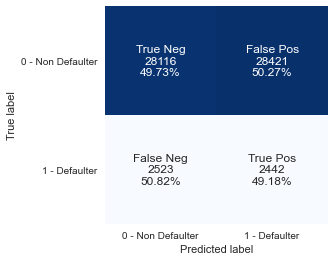

In [39]:
# Fonction pour afficher la matrice de confusion
display_matrix_confusion(cm)

**Analyse:**

Si on regarde la matrice de confusion, on remarque les points suivants:
- **True Negative (TN)**: personnes prédites comme non-défaillantes, et qui sont réellement non-défaillantes.

- **False Negative (FN)**: personnes qui ont été prédites comme non défaillantes par le modèle mais qui étaient en fait des défaillants.

- **False Positive (FP)**: personnes qui ont été prédites comme défaillantes par le modèle mais qui étaient en fait non défaillants.

- **True Positive (TP)**: personnes prédites comme défaillantes, et qui sont rééllement défaillantes.

On remarque que la métrique AUC (proche de 0,5) est mauvaise, il y autant de bonnes et mauvaises préductins par classe.

L'objectif pour notre modèle de scoring est de **minimiser les faux négatifs (FN)**, c'est-à-dire les personnes qui ont été prédites comme non-défauts par le modèle mais qui étaient en fait des défaillants.

Il est important de ne pas passer à côté d'un défaillant comme étant classé comme non défaillant car le coût des erreurs pourrait être très élevé. 

Cependant, même si certains des non-défauts sont classés comme défaillants (faux positifs), ils peuvent postuler à nouveau et demander une vérification de profil spéciale par des experts. 

De cette façon, nous réduisons le coût des erreurs de modèle.

D'un autre côté, compte tenu du déséquilibre des classes (proportion de classes 0 - Non Défaillances de 92 % contre proportion de classes 1 - Défaillances de 8 %), la précision (accuracy) ne sera pas une mesure correcte pour évaluer les performances du modèle. 

Pour corriger, le problème de déséquilibre des classes, nous allons étudier des techniques d'échantillonnage des données sur un modèle LogisticRegression:
- **sur-échantillonnage**: on donne plus de poids aux événements rares (en les comptant plusieurs fois). Utilisation de SMOTE ou RandomOverSampler.
- **sous-échantillonnage**: on donne moins de poids aux événements les plus communs (on réduit leur nombre). Utilisation du package imbalanced-learn (RandomUnderSampler).
- **en utilisant des poids sur les classes (class_weight)**

Enfin, nous allons proposer une fonction de coût comme métrique personnalisée.

## 5.3 Métrique personnalisée: fonction de coût

**La fonction de revenu net ou de coût** est dérivée en accordant des poids au coût pour chaque faux positif et faux négatif et au revenu pour chaque vrai négatif et vrai positif. On accorde plus de poids aux faux négatifs car on considère que le coût d'un faux négatif est plus important pour la banque entraînant une plus grade perte qu'un faux positif.

L'objectif est de minimiser les coût des faux négatifs dans la fonction de revenu net sur la base des prédictions correctes et incorrectes.

Signification des poids dans la fonction de revenu net:

- **True negative revenue weight (TNRW)** = poids accordé au revenu des intérêts annuels moyen d'un client qui rembourse un prêt. 

On lui accorde **un poids de +10 aux TN**.


- **True Positive revenue weight (TPRW)** = poids accordé à la perte évitée si on accorde un crédit à un client défaillant. On considère que le revenu pour les TP est égal à 1, car il y a peu de  revenu généré à proprement parler dans ce cas. 

On accorde donc **un poids de 1 aux TP.**
 

- **False Positive cost (FPCW)** = poids accordé au coût représenté par les revenus d'intérêts moyens perdus en prédisant un client en tant que défaillant, ne lui accordant pas le prêt. On considère que ce coût est de moindre importance que le coût d'un faux négatif, car la banque perd dans la cas de FP uniquement les intérêts alors qu'il peut perdre tout le capital dans le cadre de FN.

On accorde donc **un poids de -1 aux FP**.

- **False Negative cost (FNCW)** = poids accordé au coût représenté par le montant moyen du capital perdu en accordant un prêt à un client défaillant. On considère que ce coût est 100 fois plus important que le coût des FP.

On accorde donc **un poids de -100 aux FN**.

**Revenu net = (TN x TNRW) + (TP x TPRW) + (FP x FPCW) + (FN x FNCW)**

On peut mettre en perspective et normaliser la fonction de revenu net avec la fonction de revenu net qui permet de produire le modèle parfait prédisant les vraies classes. Dans ce cas, la formule est la suivante:

**Revenu net optimum = (TN+FP) x TNRW + (TP+FN) x TPRW**

In [40]:
# Définition de poids
tnrw = 10
tprw = 1
fpcw = -1
fncw = -100

## 5.4 Modèle baseline classifier: Logistic Regression

### 5.4.1 Détermination d'une méthode pour les classes déséquilibrées

#### 5.4.1.1 Avec classes déséquilibrées

In [41]:
# Modèle baseline
log = LogisticRegression()

# Appel fonction modélisation
cm, classif_report, result_metrics = model_baseline(log, "LogisticRegression",
                                                    X_train, y_train, X_test, 
                                                    y_test, results_metrics,
                                                    "O", tnrw, tprw, fpcw, fncw,
                                                    None)

AUC score:  0.5116153025544982


In [42]:
print("Matrice de confusion pour DummyClassifier: ", cm, sep="\n")

Matrice de confusion pour DummyClassifier: 
[[56427   110]
 [ 4840   125]]


In [43]:
print("Rapport sur classification pour DummyClassifier: ", classif_report, sep="\n")

Rapport sur classification pour DummyClassifier: 
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56537
           1       0.53      0.03      0.05      4965

    accuracy                           0.92     61502
   macro avg       0.73      0.51      0.50     61502
weighted avg       0.89      0.92      0.88     61502



In [44]:
result_metrics

,Modèle,Méthode Imbalanced class,Optim_params,Accuracy,AUC,Custom cost function,Optimum cost function,Custom/Optimum cost function ratio,Precision classe 0 - Non Default,Precision classe 1 - Default,Recall classe 0 - Non Default,Recall classe 1 - Default,F1 score classe 0 - Non Default,F1 score classe 1 - Default
0,Dummy classifier,N/A,N/A,0.496862,0.494573,N/A,N/A,N/A,0.917654,0.079124,0.497303,0.491843,0.645040,0.136318
1,LogisticRegression,N/A,N/A,0.919515,0.511615,80285,570335,0.1408,0.921002,0.531915,0.998054,0.025176,0.957981,0.048077


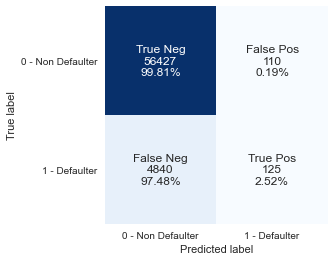

In [45]:
# Fonction pour afficher la matrice de confusion
display_matrix_confusion(cm)

Outre les métrique AUC  et fonction de coût normalisée mauvaises (repectivement 0,52 et 0,1662), on voit la prépondérance de faux négatifs (FN) pour la classe 1 (environ 94 %).

#### 5.4.1.2 Sous-échantillonnage avec RandomUnderSampler

In [46]:
under = RandomUnderSampler(sampling_strategy='auto')

In [47]:
cm, classif_report, result_metrics, X_train_bal2, y_train_bal2 = eval_imbalance_class_method(None, under, None,
                                X_train, y_train, X_test, y_test, result_metrics,
                                tnrw, tprw, fpcw, fncw, "Undersampling RandomUnderSampler")

Nombre individus par classe sur y_train:
Counter({0: 226145, 1: 19860})
Méthode de sous-échantillonnage: Undersampling RandomUnderSampler
Nombre individus par classe sur y_train_imb après rééquilibrage des classes:
Counter({0: 19860, 1: 19860})
AUC score:  0.6934999994032908


In [48]:
print("Matrice de confusion pour LogisticRegression - under sampling: ", 
      cm, sep="\n")

Matrice de confusion pour LogisticRegression - under sampling: 
[[39211 17326]
 [ 1522  3443]]


In [49]:
print("Rapport sur classification pour LogisticRegression - under sampling: ", classif_report, sep="\n")

Rapport sur classification pour LogisticRegression - under sampling: 
              precision    recall  f1-score   support

           0       0.96      0.69      0.81     56537
           1       0.17      0.69      0.27      4965

    accuracy                           0.69     61502
   macro avg       0.56      0.69      0.54     61502
weighted avg       0.90      0.69      0.76     61502



In [50]:
result_metrics

,Modèle,Méthode Imbalanced class,Optim_params,Accuracy,AUC,Custom cost function,Optimum cost function,Custom/Optimum cost function ratio,Precision classe 0 - Non Default,Precision classe 1 - Default,Recall classe 0 - Non Default,Recall classe 1 - Default,F1 score classe 0 - Non Default,F1 score classe 1 - Default
0,Dummy classifier,N/A,N/A,0.496862,0.494573,N/A,N/A,N/A,0.917654,0.079124,0.497303,0.491843,0.645040,0.136318
1,LogisticRegression,N/A,N/A,0.919515,0.511615,80285,570335,0.1408,0.921002,0.531915,0.998054,0.025176,0.957981,0.048077
2,LogisticRegression,Undersampling RandomUnderSampler,N/A,0.693538,0.693500,226027,570335,0.3963,0.962635,0.165776,0.693546,0.693454,0.806230,0.267584


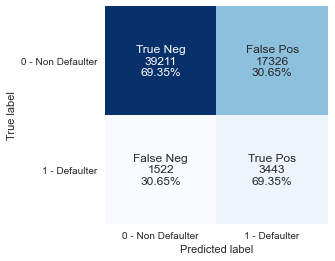

In [51]:
# Fonction pour afficher la matrice de confusion
display_matrix_confusion(cm)

On remarque que les métriques AUC et fonction de coût normalisée sont meilleures que pour les sur-échantillonnage RandomOverSampler, respectivement 0,7112 et 0,4355.

De plus, il y un peu moins de faux négatifs.

#### 5.4.1.4 Equilibrage par class_weights

In [52]:
# Modèle baseline
log2 = LogisticRegression(class_weight="balanced")

# Appel fonction modélisation
cm, classif_report, result_metrics = model_baseline(log2, 
                                                    "LogisticRegression (class_weight)",
                                                    X_train, y_train, X_test, 
                                                    y_test, results_metrics,
                                                    "O", tnrw, tprw, fpcw, fncw,
                                                    "class weights")

AUC score:  0.6949874620691052


In [53]:
print("Matrice de confusion pour LogisticRegression - class_weight: ", 
      cm, sep="\n")

Matrice de confusion pour LogisticRegression - class_weight: 
[[39550 16987]
 [ 1537  3428]]


In [54]:
print("Rapport sur classification pour LogisticRegression - class_weight: ", 
      classif_report, sep="\n")

Rapport sur classification pour LogisticRegression - class_weight: 
              precision    recall  f1-score   support

           0       0.96      0.70      0.81     56537
           1       0.17      0.69      0.27      4965

    accuracy                           0.70     61502
   macro avg       0.57      0.69      0.54     61502
weighted avg       0.90      0.70      0.77     61502



In [55]:
result_metrics

,Modèle,Méthode Imbalanced class,Optim_params,Accuracy,AUC,Custom cost function,Optimum cost function,Custom/Optimum cost function ratio,Precision classe 0 - Non Default,Precision classe 1 - Default,Recall classe 0 - Non Default,Recall classe 1 - Default,F1 score classe 0 - Non Default,F1 score classe 1 - Default
0,Dummy classifier,N/A,N/A,0.496862,0.494573,N/A,N/A,N/A,0.917654,0.079124,0.497303,0.491843,0.645040,0.136318
1,LogisticRegression,N/A,N/A,0.919515,0.511615,80285,570335,0.1408,0.921002,0.531915,0.998054,0.025176,0.957981,0.048077
2,LogisticRegression,Undersampling RandomUnderSampler,N/A,0.693538,0.693500,226027,570335,0.3963,0.962635,0.165776,0.693546,0.693454,0.806230,0.267584
3,LogisticRegression (class_weight),Class weights,N/A,0.698807,0.694987,228241,570335,0.4002,0.962592,0.167916,0.699542,0.690433,0.810252,0.270134


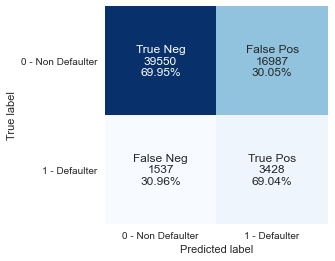

In [56]:
# Fonction pour afficher la matrice de confusion
display_matrix_confusion(cm)

Nous obtenons un AUC de 0,7126 et un fonction de coût normalisée de 0,4380, avec le plus faible taux de faux négatifs (30,67%).

#### 5.4.1.5 Conclusion sur la méthode d'équilibrage des classes choisie

La méthode choisie pour pallier au déséquilibre des classes est **la méthode par class_weight dans les modèles**.

**Remarque: les méthodes d'équilibrage des classes par sur-échantillonnage (RandomoverSampler et SMOTE) n'ont pas été retenues car trop consommatrices de ressources mémoire dans mon cas.**

Cette méthode permet de maximiser la métrique AUC (0.6949) et la fonction de coût normalisée (0,3995) et de minimiser le pourcentage de faux négatifs (31,03 %) pour la classe 1.

## 5.5 Optimisation  hyper-paramètres GridSearchCV

### 5.5.1 Logistic Regression

In [57]:
# Liste des hyper-paramètres à régler par modèle
model_hyper_params_1 = {
'LogisticRegression'  : 
    {'regressor': {'model' : LogisticRegression(),
                   'model_txt' : 'LogisticRegression'}, 
                   'hyperparam_grid' : {
                        'max_iter' : [500],
                        'solver' : ['sag', 'saga'],
                        'C' : [10, 1.0, 0.1, 0.01]}}}


In [58]:
# Appel fonction pour optimisation hyper-paramètres LogisticRegression
optim_hyperparam_model(X_train_bal2, X_test, y_train_bal2,y_test,
               model_hyper_params_1['LogisticRegression']['regressor']['model'], 
               model_hyper_params_1['LogisticRegression']['hyperparam_grid'],
               model_hyper_params_1['LogisticRegression']['regressor']['model_txt'],
               5)

Optimisation des hyper-paramètres pour le modèle LogisticRegression
---------------------------------------------------------------------------------

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] END .....................C=10, max_iter=500, solver=sag; total time=  50.3s
[CV] END .....................C=10, max_iter=500, solver=sag; total time=  54.0s
[CV] END .....................C=10, max_iter=500, solver=sag; total time=  57.7s
[CV] END .....................C=10, max_iter=500, solver=sag; total time=  52.4s
[CV] END .....................C=10, max_iter=500, solver=sag; total time=  55.2s
[CV] END ....................C=10, max_iter=500, solver=saga; total time= 1.2min
[CV] END ....................C=10, max_iter=500, solver=saga; total time= 1.2min
[CV] END ....................C=10, max_iter=500, solver=saga; total time= 1.2min
[CV] END ....................C=10, max_iter=500, solver=saga; total time= 1.1min
[CV] END ....................C=10, max_iter=500, solver=saga

### 5.5.2 SVC

In [59]:
# Liste des hyper-paramètres à régler par modèle
model_hyper_params_2 = {
'SVC'               : 
    {'regressor': {'model' : SVC(),
                   'model_txt' : 'SVC'},
                   'hyperparam_grid': {
                       'max_iter' : [500],
                       'C': [50, 10, 1.0, 0.1, 0.01],
                       'kernel': ['poly', 'rbf', 'sigmoid'],
                       'gamma': ['scale']}}}

In [60]:
# Appel fonction pour optimisation hyper-paramètres SVC
optim_hyperparam_model(X_train_bal2, X_test, y_train_bal2,y_test,
               model_hyper_params_2['SVC']['regressor']['model'], 
               model_hyper_params_2['SVC']['hyperparam_grid'],
               model_hyper_params_2['SVC']['regressor']['model_txt'],
               5)

Optimisation des hyper-paramètres pour le modèle SVC
---------------------------------------------------------------------------------

Fitting 5 folds for each of 15 candidates, totalling 75 fits
[CV] END .......C=50, gamma=scale, kernel=poly, max_iter=500; total time=   9.0s
[CV] END .......C=50, gamma=scale, kernel=poly, max_iter=500; total time=   9.0s
[CV] END .......C=50, gamma=scale, kernel=poly, max_iter=500; total time=   8.9s
[CV] END .......C=50, gamma=scale, kernel=poly, max_iter=500; total time=   8.4s
[CV] END .......C=50, gamma=scale, kernel=poly, max_iter=500; total time=   8.5s
[CV] END ........C=50, gamma=scale, kernel=rbf, max_iter=500; total time=  10.2s
[CV] END ........C=50, gamma=scale, kernel=rbf, max_iter=500; total time=   9.1s
[CV] END ........C=50, gamma=scale, kernel=rbf, max_iter=500; total time=   9.4s
[CV] END ........C=50, gamma=scale, kernel=rbf, max_iter=500; total time=   9.3s
[CV] END ........C=50, gamma=scale, kernel=rbf, max_iter=500; total time= 

### 5.5.3 Random Forest Classifier

In [61]:
# Liste des hyper-paramètres à régler par modèle
model_hyper_params_3 = {
'RandomForestClass'   : 
    {'regressor': {'model' : RandomForestClassifier(), 
                   'model_txt' : 'RandomForestClassifier'},
                   'hyperparam_grid': { 
                                       'max_features' : ['log2', 'sqrt'], 
                                       'n_estimators' : [10, 100, 500]}}}

In [62]:
# Appel fonction pour optimisation hyper-paramètres Random Forest
optim_hyperparam_model(X_train_bal2, X_test, y_train_bal2, y_test,
               model_hyper_params_3['RandomForestClass']['regressor']['model'], 
               model_hyper_params_3['RandomForestClass']['hyperparam_grid'],
               model_hyper_params_3['RandomForestClass']['regressor']['model_txt'],
               5)

Optimisation des hyper-paramètres pour le modèle RandomForestClassifier
---------------------------------------------------------------------------------

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] END .................max_features=log2, n_estimators=10; total time=   1.7s
[CV] END .................max_features=log2, n_estimators=10; total time=   1.5s
[CV] END .................max_features=log2, n_estimators=10; total time=   1.6s
[CV] END .................max_features=log2, n_estimators=10; total time=   1.9s
[CV] END .................max_features=log2, n_estimators=10; total time=   1.8s
[CV] END ................max_features=log2, n_estimators=100; total time=  15.5s
[CV] END ................max_features=log2, n_estimators=100; total time=  15.9s
[CV] END ................max_features=log2, n_estimators=100; total time=  15.7s
[CV] END ................max_features=log2, n_estimators=100; total time=  15.7s
[CV] END ................max_features=log2, n_estimators

### 5.5.4 Gradien Boosting Classifier

In [63]:
# Liste des hyper-paramètres à régler par modèle
model_hyper_params_4 = {
'GradientBoostClass'   : 
    {'regressor': {'model' : GradientBoostingClassifier(), 
                   'model_txt' : 'GradientBoostingClassifier'},
                   'hyperparam_grid': {'learning_rate': [0.1, 0.05, 0.01],
                                       'n_estimators'    : [100]}}}

In [64]:
# Appel fonction pour optimisation hyper-paramètres Gradient Boosting Classifier
optim_hyperparam_model(X_train_bal2, X_test, y_train_bal2, y_test,
               model_hyper_params_4['GradientBoostClass']['regressor']['model'], 
               model_hyper_params_4['GradientBoostClass']['hyperparam_grid'],
               model_hyper_params_4['GradientBoostClass']['regressor']['model_txt'],
               5)

Optimisation des hyper-paramètres pour le modèle GradientBoostingClassifier
---------------------------------------------------------------------------------

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] END ................learning_rate=0.1, n_estimators=100; total time= 2.3min
[CV] END ................learning_rate=0.1, n_estimators=100; total time= 2.6min
[CV] END ................learning_rate=0.1, n_estimators=100; total time= 2.3min
[CV] END ................learning_rate=0.1, n_estimators=100; total time= 2.1min
[CV] END ................learning_rate=0.1, n_estimators=100; total time= 2.1min
[CV] END ...............learning_rate=0.05, n_estimators=100; total time= 2.1min
[CV] END ...............learning_rate=0.05, n_estimators=100; total time= 2.1min
[CV] END ...............learning_rate=0.05, n_estimators=100; total time= 2.3min
[CV] END ...............learning_rate=0.05, n_estimators=100; total time= 2.3min
[CV] END ...............learning_rate=0.05, n_estima

### 5.5.5 MLP Perceptron Classifier

In [65]:
# Liste des hyper-paramètres à régler par modèle
model_hyper_params_5 = {
'MLPClass'         : 
    {'regressor': {'model' : MLPClassifier(), 
                   'model_txt' : 'MLPClassifier'},
                   'hyperparam_grid': {'max_iter' : [100],
                                       'hidden_layer_sizes': [(200, 100)],
                                       'activation': ['tanh'],
                                       'solver': ['sgd', 'adam'],
                                       'alpha': [0.0001, 0.05],
                                       'learning_rate': ['adaptive']}}}

In [66]:
# Appel fonction pour optimisation hyper-paramètres Random Forest
optim_hyperparam_model(X_train_bal2, X_test, y_train_bal2, y_test,
               model_hyper_params_5['MLPClass']['regressor']['model'], 
               model_hyper_params_5['MLPClass']['hyperparam_grid'],
               model_hyper_params_5['MLPClass']['regressor']['model_txt'],
               5)

Optimisation des hyper-paramètres pour le modèle MLPClassifier
---------------------------------------------------------------------------------

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(200, 100), learning_rate=adaptive, max_iter=100, solver=sgd; total time= 1.8min
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(200, 100), learning_rate=adaptive, max_iter=100, solver=sgd; total time= 1.7min
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(200, 100), learning_rate=adaptive, max_iter=100, solver=sgd; total time= 1.8min
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(200, 100), learning_rate=adaptive, max_iter=100, solver=sgd; total time= 2.0min
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(200, 100), learning_rate=adaptive, max_iter=100, solver=sgd; total time= 1.8min
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(200, 100), learning_rate=adaptive,

## 5.6 Prédictions avec les meilleurs hyper-paramètres

### 5.6.1 Logistic Regression avec threshold = 0,5

In [67]:
model1 = LogisticRegression()
fic_hyperparam1 = './Input/LogisticRegression_optim_params.pkl'

In [68]:
cm, classif_report, result_metrics = predict_model(X_train_bal2, y_train_bal2, X_test, y_test, model1, 
              model_hyper_params_1['LogisticRegression']['regressor']['model_txt'],
              fic_hyperparam1, tnrw, tprw, fpcw, fncw, results_metrics, None,
              "UnderSampling RandomUnderSampler")

-----------------------------------------------------------------------------
Entraînement du modèle sur les hyper-paramètres optimisés: LogisticRegression
-----------------------------------------------------------------------------
Chargement du fichier des hyper-paramètres: ./Input/LogisticRegression_optim_params.pkl
Hyper-paramètres optimisés: {'C': 10, 'max_iter': 500, 'solver': 'sag'}
Prédictions avec les paramètres suivants du modèle:
{'C': 10, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 500, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'sag', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}

AUC score train:  0.702291037260826
AUC score test:  0.6958995135144947


In [69]:
print("Matrice de confusion pour LogisticRegression: ", 
      cm, sep="\n")

Matrice de confusion pour LogisticRegression: 
[[39414 17123]
 [ 1516  3449]]


In [70]:
print("Rapport sur classification pour LogisticRegression: ", classif_report, sep="\n")

Rapport sur classification pour LogisticRegression: 
              precision    recall  f1-score   support

           0       0.96      0.70      0.81     56537
           1       0.17      0.69      0.27      4965

    accuracy                           0.70     61502
   macro avg       0.57      0.70      0.54     61502
weighted avg       0.90      0.70      0.77     61502



In [71]:
result_metrics

,Modèle,Méthode Imbalanced class,Optim_params,Accuracy,AUC,Custom cost function,Optimum cost function,Custom/Optimum cost function ratio,Precision classe 0 - Non Default,Precision classe 1 - Default,Recall classe 0 - Non Default,Recall classe 1 - Default,F1 score classe 0 - Non Default,F1 score classe 1 - Default
0,Dummy classifier,N/A,N/A,0.496862,0.494573,N/A,N/A,N/A,0.917654,0.079124,0.497303,0.491843,0.645040,0.136318
1,LogisticRegression,N/A,N/A,0.919515,0.511615,80285,570335,0.1408,0.921002,0.531915,0.998054,0.025176,0.957981,0.048077
2,LogisticRegression,Undersampling RandomUnderSampler,N/A,0.693538,0.693500,226027,570335,0.3963,0.962635,0.165776,0.693546,0.693454,0.806230,0.267584
3,LogisticRegression (class_weight),Class weights,N/A,0.698807,0.694987,228241,570335,0.4002,0.962592,0.167916,0.699542,0.690433,0.810252,0.270134
4,LogisticRegression,UnderSampling RandomUnderSampler,"{'C': 10, 'max_iter': 500, 'solver': 'sag'}",0.696937,0.695900,228866,570335,0.4013,0.962961,0.167655,0.697136,0.694663,0.808766,0.270118


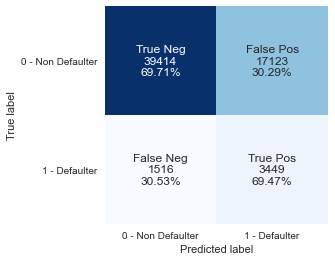

In [72]:
# Fonction pour afficher la matrice de confusion
display_matrix_confusion(cm)

### 5.6.2 SVC avec threshold = 0,5

In [73]:
model2 = SVC()
fic_hyperparam2 = './Input/SVC_optim_params.pkl'

In [74]:
cm, classif_report, result_metrics = predict_model(X_train_bal2, y_train_bal2, X_test, y_test, model2, 
              model_hyper_params_2['SVC']['regressor']['model_txt'],
              fic_hyperparam2, tnrw, tprw, fpcw, fncw, results_metrics, None,
              "UnderSampling RandomUnderSampler")

-----------------------------------------------------------------------------
Entraînement du modèle sur les hyper-paramètres optimisés: SVC
-----------------------------------------------------------------------------
Chargement du fichier des hyper-paramètres: ./Input/SVC_optim_params.pkl
Hyper-paramètres optimisés: {'C': 0.1, 'gamma': 'scale', 'kernel': 'sigmoid', 'max_iter': 500}
Prédictions avec les paramètres suivants du modèle:
{'C': 0.1, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'sigmoid', 'max_iter': 500, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}

AUC score train:  0.5004028197381672
AUC score test:  0.5006193468363124


In [75]:
print("Matrice de confusion pour LogisticRegression: ", 
      cm, sep="\n")

Matrice de confusion pour LogisticRegression: 
[[  275 56262]
 [   18  4947]]


In [76]:
print("Rapport sur classification pour LogisticRegression: ", classif_report, sep="\n")

Rapport sur classification pour LogisticRegression: 
              precision    recall  f1-score   support

           0       0.94      0.00      0.01     56537
           1       0.08      1.00      0.15      4965

    accuracy                           0.08     61502
   macro avg       0.51      0.50      0.08     61502
weighted avg       0.87      0.08      0.02     61502



In [77]:
result_metrics

,Modèle,Méthode Imbalanced class,Optim_params,Accuracy,AUC,Custom cost function,Optimum cost function,Custom/Optimum cost function ratio,Precision classe 0 - Non Default,Precision classe 1 - Default,Recall classe 0 - Non Default,Recall classe 1 - Default,F1 score classe 0 - Non Default,F1 score classe 1 - Default
0,Dummy classifier,N/A,N/A,0.496862,0.494573,N/A,N/A,N/A,0.917654,0.079124,0.497303,0.491843,0.645040,0.136318
1,LogisticRegression,N/A,N/A,0.919515,0.511615,80285,570335,0.1408,0.921002,0.531915,0.998054,0.025176,0.957981,0.048077
2,LogisticRegression,Undersampling RandomUnderSampler,N/A,0.693538,0.693500,226027,570335,0.3963,0.962635,0.165776,0.693546,0.693454,0.806230,0.267584
3,LogisticRegression (class_weight),Class weights,N/A,0.698807,0.694987,228241,570335,0.4002,0.962592,0.167916,0.699542,0.690433,0.810252,0.270134
4,LogisticRegression,UnderSampling RandomUnderSampler,"{'C': 10, 'max_iter': 500, 'solver': 'sag'}",0.696937,0.695900,228866,570335,0.4013,0.962961,0.167655,0.697136,0.694663,0.808766,0.270118
5,SVC,UnderSampling RandomUnderSampler,"{'C': 0.1, 'gamma': 'scale', 'kernel': 'sigmoi...",0.084908,0.500619,-50365,570335,-0.0883,0.938567,0.080821,0.004864,0.996375,0.009678,0.149515


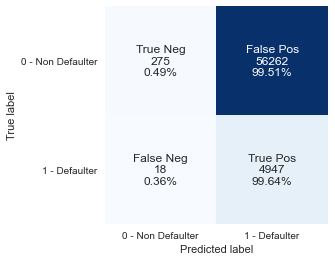

In [78]:
# Fonction pour afficher la matrice de confusion
display_matrix_confusion(cm)

### 5.6.3 Random Forest Classifier avec threshold = 0,5

In [79]:
model3 = RandomForestClassifier()
fic_hyperparam3 = './Input/RandomForestClassifier_optim_params.pkl'

In [80]:
cm, classif_report, result_metrics = predict_model(X_train_bal2, y_train_bal2, X_test, y_test, model3, 
              model_hyper_params_3['RandomForestClass']['regressor']['model_txt'],
              fic_hyperparam3,  tnrw, tprw, fpcw, fncw, results_metrics, None,
              "UnderSampling RandomUnderSampler")

-----------------------------------------------------------------------------
Entraînement du modèle sur les hyper-paramètres optimisés: RandomForestClassifier
-----------------------------------------------------------------------------
Chargement du fichier des hyper-paramètres: ./Input/RandomForestClassifier_optim_params.pkl
Hyper-paramètres optimisés: {'max_features': 'sqrt', 'n_estimators': 500}
Prédictions avec les paramètres suivants du modèle:
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 500, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}

AUC score train:  1.0
AUC score test:  0.6952516386305034


In [81]:
print("Matrice de confusion pour Random Forest Classifier: ", 
      cm, sep="\n")

Matrice de confusion pour Random Forest Classifier: 
[[39113 17424]
 [ 1496  3469]]


In [82]:
print("Rapport sur classification pour LogisticRegression: ", classif_report, sep="\n")

Rapport sur classification pour LogisticRegression: 
              precision    recall  f1-score   support

           0       0.96      0.69      0.81     56537
           1       0.17      0.70      0.27      4965

    accuracy                           0.69     61502
   macro avg       0.56      0.70      0.54     61502
weighted avg       0.90      0.69      0.76     61502



In [83]:
result_metrics

,Modèle,Méthode Imbalanced class,Optim_params,Accuracy,AUC,Custom cost function,Optimum cost function,Custom/Optimum cost function ratio,Precision classe 0 - Non Default,Precision classe 1 - Default,Recall classe 0 - Non Default,Recall classe 1 - Default,F1 score classe 0 - Non Default,F1 score classe 1 - Default
0,Dummy classifier,N/A,N/A,0.496862,0.494573,N/A,N/A,N/A,0.917654,0.079124,0.497303,0.491843,0.645040,0.136318
1,LogisticRegression,N/A,N/A,0.919515,0.511615,80285,570335,0.1408,0.921002,0.531915,0.998054,0.025176,0.957981,0.048077
2,LogisticRegression,Undersampling RandomUnderSampler,N/A,0.693538,0.693500,226027,570335,0.3963,0.962635,0.165776,0.693546,0.693454,0.806230,0.267584
3,LogisticRegression (class_weight),Class weights,N/A,0.698807,0.694987,228241,570335,0.4002,0.962592,0.167916,0.699542,0.690433,0.810252,0.270134
4,LogisticRegression,UnderSampling RandomUnderSampler,"{'C': 10, 'max_iter': 500, 'solver': 'sag'}",0.696937,0.695900,228866,570335,0.4013,0.962961,0.167655,0.697136,0.694663,0.808766,0.270118
5,SVC,UnderSampling RandomUnderSampler,"{'C': 0.1, 'gamma': 'scale', 'kernel': 'sigmoi...",0.084908,0.500619,-50365,570335,-0.0883,0.938567,0.080821,0.004864,0.996375,0.009678,0.149515
6,RandomForestClassifier,UnderSampling RandomUnderSampler,"{'max_features': 'sqrt', 'n_estimators': 500}",0.692368,0.695252,227575,570335,0.399,0.963161,0.166036,0.691812,0.698691,0.805242,0.268312


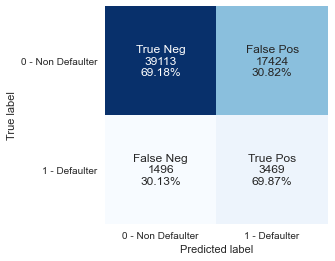

In [84]:
# Fonction pour afficher la matrice de confusion
display_matrix_confusion(cm)

### 5.6.4 Gradient Boosting Classifier avec threshold = 0,5

In [85]:
model4 = GradientBoostingClassifier()
fic_hyperparam4 = './Input/GradientBoostingClassifier_optim_params.pkl'

In [86]:
cm, classif_report, result_metrics = predict_model(X_train_bal2, y_train_bal2, X_test, y_test, model4, 
              model_hyper_params_4['GradientBoostClass']['regressor']['model_txt'],
              fic_hyperparam4, tnrw, tprw, fpcw, fncw, results_metrics, None,
              "UnderSampling RandomUnderSampler")

-----------------------------------------------------------------------------
Entraînement du modèle sur les hyper-paramètres optimisés: GradientBoostingClassifier
-----------------------------------------------------------------------------
Chargement du fichier des hyper-paramètres: ./Input/GradientBoostingClassifier_optim_params.pkl
Hyper-paramètres optimisés: {'learning_rate': 0.1, 'n_estimators': 100}
Prédictions avec les paramètres suivants du modèle:
{'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1, 'loss': 'deviance', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_iter_no_change': None, 'random_state': None, 'subsample': 1.0, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}

AUC score train:  0.7137713997985902
AUC score test:  0.703778746180

In [87]:
print("Matrice de confusion pour Gradient Boosting classifier: ", 
      cm, sep="\n")

Matrice de confusion pour Gradient Boosting classifier: 
[[39542 16995]
 [ 1449  3516]]


In [88]:
print("Rapport sur classification pour Gradient Boosting Classifier : ", classif_report, sep="\n")

Rapport sur classification pour Gradient Boosting Classifier : 
              precision    recall  f1-score   support

           0       0.96      0.70      0.81     56537
           1       0.17      0.71      0.28      4965

    accuracy                           0.70     61502
   macro avg       0.57      0.70      0.54     61502
weighted avg       0.90      0.70      0.77     61502



In [89]:
result_metrics

,Modèle,Méthode Imbalanced class,Optim_params,Accuracy,AUC,Custom cost function,Optimum cost function,Custom/Optimum cost function ratio,Precision classe 0 - Non Default,Precision classe 1 - Default,Recall classe 0 - Non Default,Recall classe 1 - Default,F1 score classe 0 - Non Default,F1 score classe 1 - Default
0,Dummy classifier,N/A,N/A,0.496862,0.494573,N/A,N/A,N/A,0.917654,0.079124,0.497303,0.491843,0.645040,0.136318
1,LogisticRegression,N/A,N/A,0.919515,0.511615,80285,570335,0.1408,0.921002,0.531915,0.998054,0.025176,0.957981,0.048077
2,LogisticRegression,Undersampling RandomUnderSampler,N/A,0.693538,0.693500,226027,570335,0.3963,0.962635,0.165776,0.693546,0.693454,0.806230,0.267584
3,LogisticRegression (class_weight),Class weights,N/A,0.698807,0.694987,228241,570335,0.4002,0.962592,0.167916,0.699542,0.690433,0.810252,0.270134
4,LogisticRegression,UnderSampling RandomUnderSampler,"{'C': 10, 'max_iter': 500, 'solver': 'sag'}",0.696937,0.695900,228866,570335,0.4013,0.962961,0.167655,0.697136,0.694663,0.808766,0.270118
5,SVC,UnderSampling RandomUnderSampler,"{'C': 0.1, 'gamma': 'scale', 'kernel': 'sigmoi...",0.084908,0.500619,-50365,570335,-0.0883,0.938567,0.080821,0.004864,0.996375,0.009678,0.149515
6,RandomForestClassifier,UnderSampling RandomUnderSampler,"{'max_features': 'sqrt', 'n_estimators': 500}",0.692368,0.695252,227575,570335,0.399,0.963161,0.166036,0.691812,0.698691,0.805242,0.268312
7,GradientBoostingClassifier,UnderSampling RandomUnderSampler,"{'learning_rate': 0.1, 'n_estimators': 100}",0.700107,0.703779,237041,570335,0.4156,0.964651,0.171420,0.699400,0.708157,0.810885,0.276024


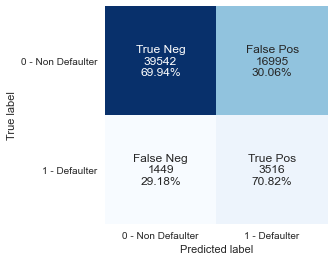

In [90]:
# Fonction pour afficher la matrice de confusion
display_matrix_confusion(cm)

### 5.6.5 MLP Perceptron Classifier avec threshold = 0,5

In [91]:
model5 = MLPClassifier()
fic_hyperparam5 = './Input/MLPClassifier_optim_params.pkl'

In [92]:
cm, classif_report, result_metrics = predict_model(X_train_bal2, y_train_bal2, X_test, y_test, model5, 
              model_hyper_params_5['MLPClass']['regressor']['model_txt'],
              fic_hyperparam5, tnrw, tprw, fpcw, fncw, results_metrics, None,
              "UnderSampling RandomUnderSampler")

-----------------------------------------------------------------------------
Entraînement du modèle sur les hyper-paramètres optimisés: MLPClassifier
-----------------------------------------------------------------------------
Chargement du fichier des hyper-paramètres: ./Input/MLPClassifier_optim_params.pkl
Hyper-paramètres optimisés: {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (200, 100), 'learning_rate': 'adaptive', 'max_iter': 100, 'solver': 'sgd'}
Prédictions avec les paramètres suivants du modèle:
{'activation': 'tanh', 'alpha': 0.0001, 'batch_size': 'auto', 'beta_1': 0.9, 'beta_2': 0.999, 'early_stopping': False, 'epsilon': 1e-08, 'hidden_layer_sizes': (200, 100), 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'max_fun': 15000, 'max_iter': 100, 'momentum': 0.9, 'n_iter_no_change': 10, 'nesterovs_momentum': True, 'power_t': 0.5, 'random_state': None, 'shuffle': True, 'solver': 'sgd', 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': False, 'warm

In [93]:
print("Matrice de confusion pour MLP Perceptron Classifier: ", 
      cm, sep="\n")

Matrice de confusion pour MLP Perceptron Classifier: 
[[39585 16952]
 [ 1551  3414]]


In [94]:
print("Rapport sur classification pour MLP Perceptron Classifier : ", classif_report, sep="\n")

Rapport sur classification pour MLP Perceptron Classifier : 
              precision    recall  f1-score   support

           0       0.96      0.70      0.81     56537
           1       0.17      0.69      0.27      4965

    accuracy                           0.70     61502
   macro avg       0.56      0.69      0.54     61502
weighted avg       0.90      0.70      0.77     61502



In [95]:
result_metrics

,Modèle,Méthode Imbalanced class,Optim_params,Accuracy,AUC,Custom cost function,Optimum cost function,Custom/Optimum cost function ratio,Precision classe 0 - Non Default,Precision classe 1 - Default,Recall classe 0 - Non Default,Recall classe 1 - Default,F1 score classe 0 - Non Default,F1 score classe 1 - Default
0,Dummy classifier,N/A,N/A,0.496862,0.494573,N/A,N/A,N/A,0.917654,0.079124,0.497303,0.491843,0.645040,0.136318
1,LogisticRegression,N/A,N/A,0.919515,0.511615,80285,570335,0.1408,0.921002,0.531915,0.998054,0.025176,0.957981,0.048077
2,LogisticRegression,Undersampling RandomUnderSampler,N/A,0.693538,0.693500,226027,570335,0.3963,0.962635,0.165776,0.693546,0.693454,0.806230,0.267584
3,LogisticRegression (class_weight),Class weights,N/A,0.698807,0.694987,228241,570335,0.4002,0.962592,0.167916,0.699542,0.690433,0.810252,0.270134
4,LogisticRegression,UnderSampling RandomUnderSampler,"{'C': 10, 'max_iter': 500, 'solver': 'sag'}",0.696937,0.695900,228866,570335,0.4013,0.962961,0.167655,0.697136,0.694663,0.808766,0.270118
5,SVC,UnderSampling RandomUnderSampler,"{'C': 0.1, 'gamma': 'scale', 'kernel': 'sigmoi...",0.084908,0.500619,-50365,570335,-0.0883,0.938567,0.080821,0.004864,0.996375,0.009678,0.149515
6,RandomForestClassifier,UnderSampling RandomUnderSampler,"{'max_features': 'sqrt', 'n_estimators': 500}",0.692368,0.695252,227575,570335,0.399,0.963161,0.166036,0.691812,0.698691,0.805242,0.268312
7,GradientBoostingClassifier,UnderSampling RandomUnderSampler,"{'learning_rate': 0.1, 'n_estimators': 100}",0.700107,0.703779,237041,570335,0.4156,0.964651,0.171420,0.699400,0.708157,0.810885,0.276024
8,MLPClassifier,UnderSampling RandomUnderSampler,"{'activation': 'tanh', 'alpha': 0.0001, 'hidde...",0.699148,0.693887,227212,570335,0.3984,0.962296,0.167632,0.700161,0.687613,0.810562,0.269551


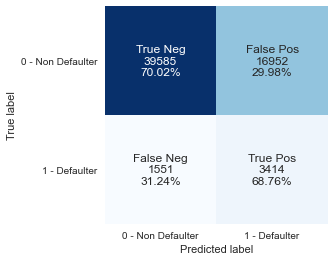

In [96]:
# Fonction pour afficher la matrice de confusion
display_matrix_confusion(cm)

### 5.6.6 Choix de modèle final

Compte tenu des métriques AUC (0,7179) et de la fonction de coût noramlisée (0,4396), **le modèle Gradient Boosting Classifier est retenu**.

## 5.7 Ajustement du seuil (threshold)

Ajustement du seuil sur le modèle retenu Gradient Boosting Classifier.

### 5.7.1 Modèle GBC avec threshold = 0,25

In [97]:
cm, classif_report, result_metrics = predict_model(X_train_bal2, y_train_bal2, X_test, y_test, model4, 
              'GradientBoostingclassifier - seuil 0.25',
              fic_hyperparam4, tnrw, tprw, fpcw, fncw, results_metrics, 0.25,
              "UnderSampling RandomUnderSampler")

-----------------------------------------------------------------------------
Entraînement du modèle sur les hyper-paramètres optimisés: GradientBoostingclassifier - seuil 0.25
-----------------------------------------------------------------------------
Chargement du fichier des hyper-paramètres: ./Input/GradientBoostingClassifier_optim_params.pkl
Hyper-paramètres optimisés: {'learning_rate': 0.1, 'n_estimators': 100}
Prédictions avec les paramètres suivants du modèle:
{'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1, 'loss': 'deviance', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_iter_no_change': None, 'random_state': None, 'subsample': 1.0, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}

AUC score train:  0.6023162134944613
AUC score test:  0

In [98]:
print("Matrice de confusion pour Gradient Boosting classifier: ", 
      cm, sep="\n")

Matrice de confusion pour Gradient Boosting classifier: 
[[12818 43719]
 [  210  4755]]


In [99]:
print("Rapport sur classification pour Gradient Boosting Classifier : ", classif_report, sep="\n")

Rapport sur classification pour Gradient Boosting Classifier : 
              precision    recall  f1-score   support

           0       0.98      0.23      0.37     56537
           1       0.10      0.96      0.18      4965

    accuracy                           0.29     61502
   macro avg       0.54      0.59      0.27     61502
weighted avg       0.91      0.29      0.35     61502



In [100]:
result_metrics

,Modèle,Méthode Imbalanced class,Optim_params,Accuracy,AUC,Custom cost function,Optimum cost function,Custom/Optimum cost function ratio,Precision classe 0 - Non Default,Precision classe 1 - Default,Recall classe 0 - Non Default,Recall classe 1 - Default,F1 score classe 0 - Non Default,F1 score classe 1 - Default
0,Dummy classifier,N/A,N/A,0.496862,0.494573,N/A,N/A,N/A,0.917654,0.079124,0.497303,0.491843,0.645040,0.136318
1,LogisticRegression,N/A,N/A,0.919515,0.511615,80285,570335,0.1408,0.921002,0.531915,0.998054,0.025176,0.957981,0.048077
2,LogisticRegression,Undersampling RandomUnderSampler,N/A,0.693538,0.693500,226027,570335,0.3963,0.962635,0.165776,0.693546,0.693454,0.806230,0.267584
3,LogisticRegression (class_weight),Class weights,N/A,0.698807,0.694987,228241,570335,0.4002,0.962592,0.167916,0.699542,0.690433,0.810252,0.270134
4,LogisticRegression,UnderSampling RandomUnderSampler,"{'C': 10, 'max_iter': 500, 'solver': 'sag'}",0.696937,0.695900,228866,570335,0.4013,0.962961,0.167655,0.697136,0.694663,0.808766,0.270118
5,SVC,UnderSampling RandomUnderSampler,"{'C': 0.1, 'gamma': 'scale', 'kernel': 'sigmoi...",0.084908,0.500619,-50365,570335,-0.0883,0.938567,0.080821,0.004864,0.996375,0.009678,0.149515
6,RandomForestClassifier,UnderSampling RandomUnderSampler,"{'max_features': 'sqrt', 'n_estimators': 500}",0.692368,0.695252,227575,570335,0.399,0.963161,0.166036,0.691812,0.698691,0.805242,0.268312
7,GradientBoostingClassifier,UnderSampling RandomUnderSampler,"{'learning_rate': 0.1, 'n_estimators': 100}",0.700107,0.703779,237041,570335,0.4156,0.964651,0.171420,0.699400,0.708157,0.810885,0.276024
8,MLPClassifier,UnderSampling RandomUnderSampler,"{'activation': 'tanh', 'alpha': 0.0001, 'hidde...",0.699148,0.693887,227212,570335,0.3984,0.962296,0.167632,0.700161,0.687613,0.810562,0.269551
9,GradientBoostingclassifier - seuil 0.25,UnderSampling RandomUnderSampler,"{'learning_rate': 0.1, 'n_estimators': 100}",0.285731,0.592211,68216,570335,0.1196,0.983881,0.098094,0.226719,0.957704,0.368519,0.177960


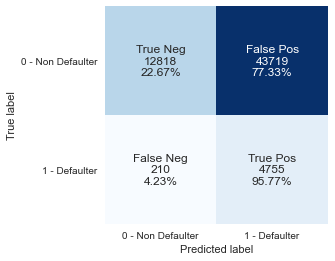

In [101]:
# Fonction pour afficher la matrice de confusion
display_matrix_confusion(cm)

On se rend compte que les faux négatifs ont été réduits considérablement, mais avec une augmentation de faux positifs.
Les métriques AUC et fonction de coût normalisée on baissé, respectivement 0,6425 et 0,2322, ce qui n'est pas acceptable. 

### 5.7.2 Modèle GBC avec threshold = 0,60

In [102]:
cm, classif_report, result_metrics = predict_model(X_train_bal2, y_train_bal2, X_test, y_test, model4, 
              'GradientBoostingclassifier - seuil 0.60',
              fic_hyperparam4, tnrw, tprw, fpcw, fncw, results_metrics, 0.60,
              "UnderSampling RandomUnderSampler")

-----------------------------------------------------------------------------
Entraînement du modèle sur les hyper-paramètres optimisés: GradientBoostingclassifier - seuil 0.60
-----------------------------------------------------------------------------
Chargement du fichier des hyper-paramètres: ./Input/GradientBoostingClassifier_optim_params.pkl
Hyper-paramètres optimisés: {'learning_rate': 0.1, 'n_estimators': 100}
Prédictions avec les paramètres suivants du modèle:
{'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1, 'loss': 'deviance', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_iter_no_change': None, 'random_state': None, 'subsample': 1.0, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}

AUC score train:  0.6943101711983888
AUC score test:  0

In [103]:
print("Matrice de confusion pour Gradient Boosting classifier: ", 
      cm, sep="\n")

Matrice de confusion pour Gradient Boosting classifier: 
[[46792  9745]
 [ 2291  2674]]


In [104]:
print("Rapport sur classification pour Gradient Boosting Classifier : ", classif_report, sep="\n")

Rapport sur classification pour Gradient Boosting Classifier : 
              precision    recall  f1-score   support

           0       0.95      0.83      0.89     56537
           1       0.22      0.54      0.31      4965

    accuracy                           0.80     61502
   macro avg       0.58      0.68      0.60     61502
weighted avg       0.89      0.80      0.84     61502



In [105]:
result_metrics

,Modèle,Méthode Imbalanced class,Optim_params,Accuracy,AUC,Custom cost function,Optimum cost function,Custom/Optimum cost function ratio,Precision classe 0 - Non Default,Precision classe 1 - Default,Recall classe 0 - Non Default,Recall classe 1 - Default,F1 score classe 0 - Non Default,F1 score classe 1 - Default
0,Dummy classifier,N/A,N/A,0.496862,0.494573,N/A,N/A,N/A,0.917654,0.079124,0.497303,0.491843,0.645040,0.136318
1,LogisticRegression,N/A,N/A,0.919515,0.511615,80285,570335,0.1408,0.921002,0.531915,0.998054,0.025176,0.957981,0.048077
2,LogisticRegression,Undersampling RandomUnderSampler,N/A,0.693538,0.693500,226027,570335,0.3963,0.962635,0.165776,0.693546,0.693454,0.806230,0.267584
3,LogisticRegression (class_weight),Class weights,N/A,0.698807,0.694987,228241,570335,0.4002,0.962592,0.167916,0.699542,0.690433,0.810252,0.270134
4,LogisticRegression,UnderSampling RandomUnderSampler,"{'C': 10, 'max_iter': 500, 'solver': 'sag'}",0.696937,0.695900,228866,570335,0.4013,0.962961,0.167655,0.697136,0.694663,0.808766,0.270118
5,SVC,UnderSampling RandomUnderSampler,"{'C': 0.1, 'gamma': 'scale', 'kernel': 'sigmoi...",0.084908,0.500619,-50365,570335,-0.0883,0.938567,0.080821,0.004864,0.996375,0.009678,0.149515
6,RandomForestClassifier,UnderSampling RandomUnderSampler,"{'max_features': 'sqrt', 'n_estimators': 500}",0.692368,0.695252,227575,570335,0.399,0.963161,0.166036,0.691812,0.698691,0.805242,0.268312
7,GradientBoostingClassifier,UnderSampling RandomUnderSampler,"{'learning_rate': 0.1, 'n_estimators': 100}",0.700107,0.703779,237041,570335,0.4156,0.964651,0.171420,0.699400,0.708157,0.810885,0.276024
8,MLPClassifier,UnderSampling RandomUnderSampler,"{'activation': 'tanh', 'alpha': 0.0001, 'hidde...",0.699148,0.693887,227212,570335,0.3984,0.962296,0.167632,0.700161,0.687613,0.810562,0.269551
9,GradientBoostingclassifier - seuil 0.25,UnderSampling RandomUnderSampler,"{'learning_rate': 0.1, 'n_estimators': 100}",0.285731,0.592211,68216,570335,0.1196,0.983881,0.098094,0.226719,0.957704,0.368519,0.177960


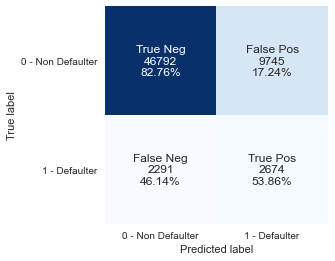

In [106]:
# Fonction pour afficher la matrice de confusion
display_matrix_confusion(cm)

A COMPLETER.

### 5.7.3 Modèle GBC avec threshold = 0,75

In [107]:
cm, classif_report, result_metrics = predict_model(X_train_bal2, y_train_bal2, X_test, y_test, model4, 
              'GradientBoostingclassifier - seuil 0.75',
              fic_hyperparam4, tnrw, tprw, fpcw, fncw, results_metrics, 0.75,
              "UnderSampling RandomUnderSampler")

-----------------------------------------------------------------------------
Entraînement du modèle sur les hyper-paramètres optimisés: GradientBoostingclassifier - seuil 0.75
-----------------------------------------------------------------------------
Chargement du fichier des hyper-paramètres: ./Input/GradientBoostingClassifier_optim_params.pkl
Hyper-paramètres optimisés: {'learning_rate': 0.1, 'n_estimators': 100}
Prédictions avec les paramètres suivants du modèle:
{'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1, 'loss': 'deviance', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_iter_no_change': None, 'random_state': None, 'subsample': 1.0, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}

AUC score train:  0.6058157099697885
AUC score test:  0

In [108]:
print("Matrice de confusion pour Gradient Boosting classifier: ", 
      cm, sep="\n")

Matrice de confusion pour Gradient Boosting classifier: 
[[54196  2341]
 [ 3807  1158]]


In [109]:
print("Rapport sur classification pour Gradient Boosting Classifier : ", classif_report, sep="\n")

Rapport sur classification pour Gradient Boosting Classifier : 
              precision    recall  f1-score   support

           0       0.93      0.96      0.95     56537
           1       0.33      0.23      0.27      4965

    accuracy                           0.90     61502
   macro avg       0.63      0.60      0.61     61502
weighted avg       0.89      0.90      0.89     61502



In [110]:
result_metrics

,Modèle,Méthode Imbalanced class,Optim_params,Accuracy,AUC,Custom cost function,Optimum cost function,Custom/Optimum cost function ratio,Precision classe 0 - Non Default,Precision classe 1 - Default,Recall classe 0 - Non Default,Recall classe 1 - Default,F1 score classe 0 - Non Default,F1 score classe 1 - Default
0,Dummy classifier,N/A,N/A,0.496862,0.494573,N/A,N/A,N/A,0.917654,0.079124,0.497303,0.491843,0.645040,0.136318
1,LogisticRegression,N/A,N/A,0.919515,0.511615,80285,570335,0.1408,0.921002,0.531915,0.998054,0.025176,0.957981,0.048077
2,LogisticRegression,Undersampling RandomUnderSampler,N/A,0.693538,0.693500,226027,570335,0.3963,0.962635,0.165776,0.693546,0.693454,0.806230,0.267584
3,LogisticRegression (class_weight),Class weights,N/A,0.698807,0.694987,228241,570335,0.4002,0.962592,0.167916,0.699542,0.690433,0.810252,0.270134
4,LogisticRegression,UnderSampling RandomUnderSampler,"{'C': 10, 'max_iter': 500, 'solver': 'sag'}",0.696937,0.695900,228866,570335,0.4013,0.962961,0.167655,0.697136,0.694663,0.808766,0.270118
5,SVC,UnderSampling RandomUnderSampler,"{'C': 0.1, 'gamma': 'scale', 'kernel': 'sigmoi...",0.084908,0.500619,-50365,570335,-0.0883,0.938567,0.080821,0.004864,0.996375,0.009678,0.149515
6,RandomForestClassifier,UnderSampling RandomUnderSampler,"{'max_features': 'sqrt', 'n_estimators': 500}",0.692368,0.695252,227575,570335,0.399,0.963161,0.166036,0.691812,0.698691,0.805242,0.268312
7,GradientBoostingClassifier,UnderSampling RandomUnderSampler,"{'learning_rate': 0.1, 'n_estimators': 100}",0.700107,0.703779,237041,570335,0.4156,0.964651,0.171420,0.699400,0.708157,0.810885,0.276024
8,MLPClassifier,UnderSampling RandomUnderSampler,"{'activation': 'tanh', 'alpha': 0.0001, 'hidde...",0.699148,0.693887,227212,570335,0.3984,0.962296,0.167632,0.700161,0.687613,0.810562,0.269551
9,GradientBoostingclassifier - seuil 0.25,UnderSampling RandomUnderSampler,"{'learning_rate': 0.1, 'n_estimators': 100}",0.285731,0.592211,68216,570335,0.1196,0.983881,0.098094,0.226719,0.957704,0.368519,0.177960


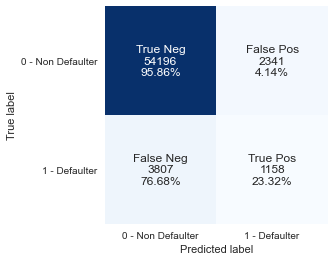

In [111]:
# Fonction pour afficher la matrice de confusion
display_matrix_confusion(cm)

A COMPLETER.

### 5.7.4 Ajustement automatique du seuil de discrimination

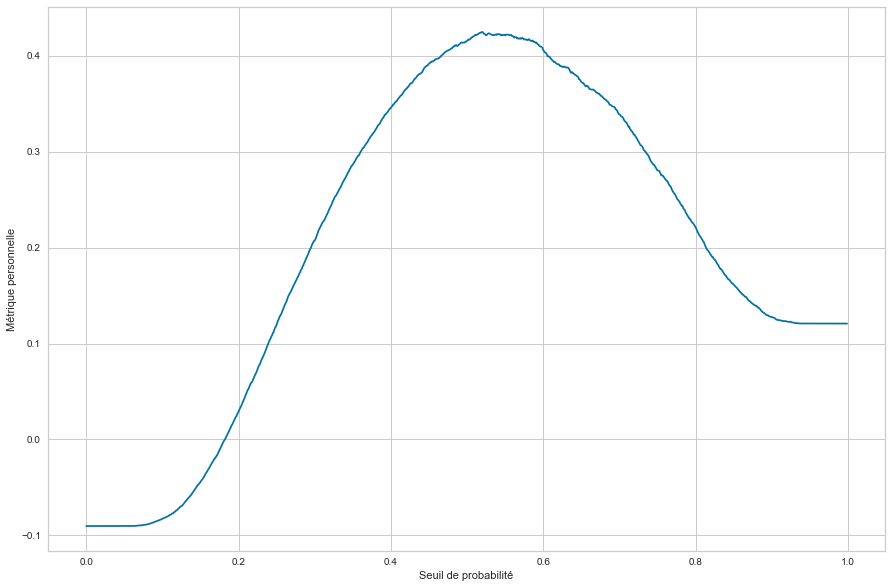

In [112]:
scor_int = []
int_threshold = np.arange(0, 1, 0.001)

model = GradientBoostingClassifier(learning_rate=0.1,n_estimators= 100)
model.fit(X_train_bal2, y_train_bal2)

# predict probabilities
proba_pred = model.predict_proba(X_test)
proba_default_payment = proba_pred[:, 1]

for s in int_threshold:
    
    # Score du modèle : 0 à 1
    y_seuil=[]

    for i in proba_default_payment:
        if i >= s:
            y_seuil.append(1)
        elif i < s:
            y_seuil.append(0)

    tn, fp, fn, tp = confusion_matrix(y_test, y_seuil, labels=[0, 1]).ravel()
    cm = metrics.confusion_matrix(y_test, y_seuil)
    
    ccf, ocf = eval_custom_metric(cm, tnrw, tprw, fpcw, fncw)
  
    scor_int.append(round(ccf/ocf,4))
    
#     scores = [round(ccf/ocf,4) for t == s]
    
# ix = np.argmax(scores)
# print('Threshold=%.3f, cost function=%.4f' % (int_threshold[ix], scores[ix])) 

# Affichage du gain en fonction du seuil de solvabilité    
plt.figure(figsize=(15, 10))
plt.plot(int_threshold, scor_int)
plt.xlabel("Seuil de probabilité")
plt.ylabel("Métrique personnelle")
plt.show()

Seuil = 0,52

### 5.7.5 Modèle GBC avec threshold = 0,52

In [113]:
cm, classif_report, result_metrics = predict_model(X_train_bal2, y_train_bal2, X_test, y_test, model4, 
              'GradientBoostingclassifier - seuil 0.52',
              fic_hyperparam4, tnrw, tprw, fpcw, fncw, results_metrics, 0.52,
              "UnderSampling RandomUnderSampler")

-----------------------------------------------------------------------------
Entraînement du modèle sur les hyper-paramètres optimisés: GradientBoostingclassifier - seuil 0.52
-----------------------------------------------------------------------------
Chargement du fichier des hyper-paramètres: ./Input/GradientBoostingClassifier_optim_params.pkl
Hyper-paramètres optimisés: {'learning_rate': 0.1, 'n_estimators': 100}
Prédictions avec les paramètres suivants du modèle:
{'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1, 'loss': 'deviance', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_iter_no_change': None, 'random_state': None, 'subsample': 1.0, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}

AUC score train:  0.7119587109768379
AUC score test:  0

In [114]:
print("Matrice de confusion pour Gradient Boosting classifier: ", 
      cm, sep="\n")

Matrice de confusion pour Gradient Boosting classifier: 
[[41135 15402]
 [ 1569  3396]]


In [115]:
print("Rapport sur classification pour Gradient Boosting Classifier : ", classif_report, sep="\n")

Rapport sur classification pour Gradient Boosting Classifier : 
              precision    recall  f1-score   support

           0       0.96      0.73      0.83     56537
           1       0.18      0.68      0.29      4965

    accuracy                           0.72     61502
   macro avg       0.57      0.71      0.56     61502
weighted avg       0.90      0.72      0.79     61502



In [116]:
result_metrics

,Modèle,Méthode Imbalanced class,Optim_params,Accuracy,AUC,Custom cost function,Optimum cost function,Custom/Optimum cost function ratio,Precision classe 0 - Non Default,Precision classe 1 - Default,Recall classe 0 - Non Default,Recall classe 1 - Default,F1 score classe 0 - Non Default,F1 score classe 1 - Default
0,Dummy classifier,N/A,N/A,0.496862,0.494573,N/A,N/A,N/A,0.917654,0.079124,0.497303,0.491843,0.645040,0.136318
1,LogisticRegression,N/A,N/A,0.919515,0.511615,80285,570335,0.1408,0.921002,0.531915,0.998054,0.025176,0.957981,0.048077
2,LogisticRegression,Undersampling RandomUnderSampler,N/A,0.693538,0.693500,226027,570335,0.3963,0.962635,0.165776,0.693546,0.693454,0.806230,0.267584
3,LogisticRegression (class_weight),Class weights,N/A,0.698807,0.694987,228241,570335,0.4002,0.962592,0.167916,0.699542,0.690433,0.810252,0.270134
4,LogisticRegression,UnderSampling RandomUnderSampler,"{'C': 10, 'max_iter': 500, 'solver': 'sag'}",0.696937,0.695900,228866,570335,0.4013,0.962961,0.167655,0.697136,0.694663,0.808766,0.270118
5,SVC,UnderSampling RandomUnderSampler,"{'C': 0.1, 'gamma': 'scale', 'kernel': 'sigmoi...",0.084908,0.500619,-50365,570335,-0.0883,0.938567,0.080821,0.004864,0.996375,0.009678,0.149515
6,RandomForestClassifier,UnderSampling RandomUnderSampler,"{'max_features': 'sqrt', 'n_estimators': 500}",0.692368,0.695252,227575,570335,0.399,0.963161,0.166036,0.691812,0.698691,0.805242,0.268312
7,GradientBoostingClassifier,UnderSampling RandomUnderSampler,"{'learning_rate': 0.1, 'n_estimators': 100}",0.700107,0.703779,237041,570335,0.4156,0.964651,0.171420,0.699400,0.708157,0.810885,0.276024
8,MLPClassifier,UnderSampling RandomUnderSampler,"{'activation': 'tanh', 'alpha': 0.0001, 'hidde...",0.699148,0.693887,227212,570335,0.3984,0.962296,0.167632,0.700161,0.687613,0.810562,0.269551
9,GradientBoostingclassifier - seuil 0.25,UnderSampling RandomUnderSampler,"{'learning_rate': 0.1, 'n_estimators': 100}",0.285731,0.592211,68216,570335,0.1196,0.983881,0.098094,0.226719,0.957704,0.368519,0.177960


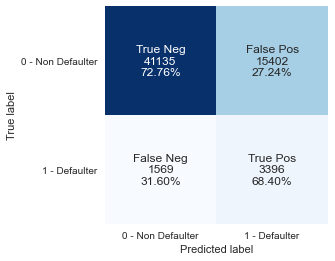

In [117]:
# Fonction pour afficher la matrice de confusion
display_matrix_confusion(cm)

A COMPLETER.

## 5.8 Features importance

### 5.8.1 Visualisation des 10 features les plus importantes

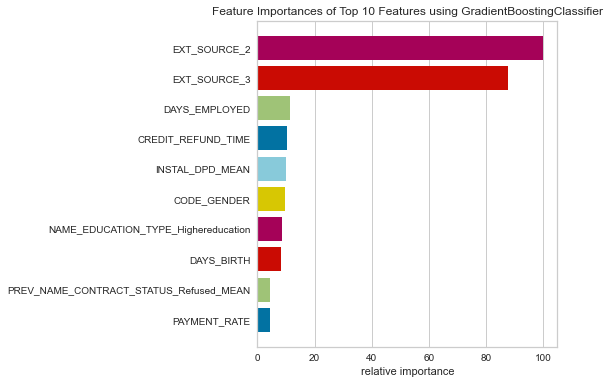

In [118]:
# Instanciation du modèle
model = GradientBoostingClassifier(learning_rate=0.1, n_estimators=100)

# Visualisation des 30 features les plus importantes 
visualizer = FeatureImportances(model, topn=10) 
                                

# Fit et affichage
visualizer.fit(X_train_bal2, y_train_bal2)
visualizer.show();

### 5.8.2 Interprétabilité globale

In [136]:
model = GradientBoostingClassifier(learning_rate=0.1, n_estimators=100)

model.fit(X_train_bal2, y_train_bal2)
y_pred = model.predict(X_test)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

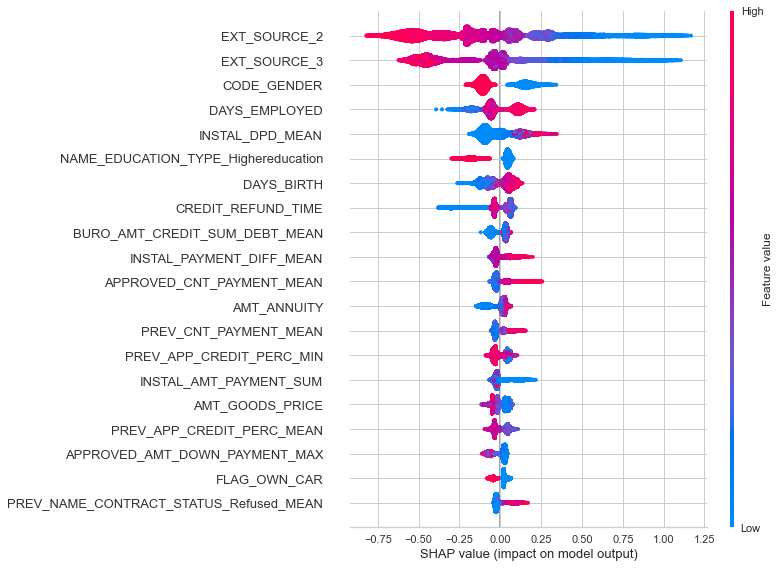

In [137]:
# SHAP summary plot
shap.summary_plot(shap_values, X_test)

### 5.8.3 Interprétabilité locale

In [163]:
# SHAP Force plot
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], X_test.iloc[0,:])

Par exemple, pour une donnée de la classe 0 "Client non défaillant" (correctement prédite), on observe que les variables suivantes sont déterminantes pour indiquer que le client appartient à la classe 0:
- sexe
- nombre de jours en activité
- prix du bien
- niveau d'éducation,...

Par ailleurs, toujours pour une donnée de la classe 0 "Client non défaillant" (correctement prédite), on observe que les variables suivantes ne sont pas déterminantes pour indiquer que le client appartient à la classe 0, mais plutôt à la classe 1 "Client défaillant":
- ext_source_2
- âge du client
- durée de remboursement du crédit,...